In [1]:
import os, sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages')

import dicom
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# ia_rf1 = 20000
zte_dir = os.path.join(os.getcwd(), 'data', 'DICOM', 'ia_rf1.20000')
#zte_dir = os.path.join(os.path.expanduser('~'), 'Box', 'RadOnc-QMRI', 'Data', '2018-04__Studies', '20180404.MP-Mk4.0.Exp0', 'E6218', '2')
n_dicoms = len(os.listdir(zte_dir))

exam = 6276
series = 2
dcm_fn_base = 'E{:d}S{:d}'.format(exam, series) + 'I{:d}.DCM'

ref_dcm = dicom.read_file(os.path.join(zte_dir, dcm_fn_base.format(1)))

(nx, ny, nz) = (
    int(ref_dcm.Columns),
    int(ref_dcm.Rows),
    int(n_dicoms)
)

(dx, dy, dz) = (
    float(ref_dcm.PixelSpacing[0]),
    float(ref_dcm.PixelSpacing[1]),
    float(ref_dcm.SliceThickness)
)

vol = np.ndarray((nx, ny, nz), dtype=ref_dcm.pixel_array.dtype)
for zi in range(nz):
    ds = dicom.read_file(os.path.join(zte_dir, dcm_fn_base.format(zi+1)))
    vol[:, :, zi] = ds.pixel_array

#print(vol.shape, (dx, dy, dz))
#print(ds)

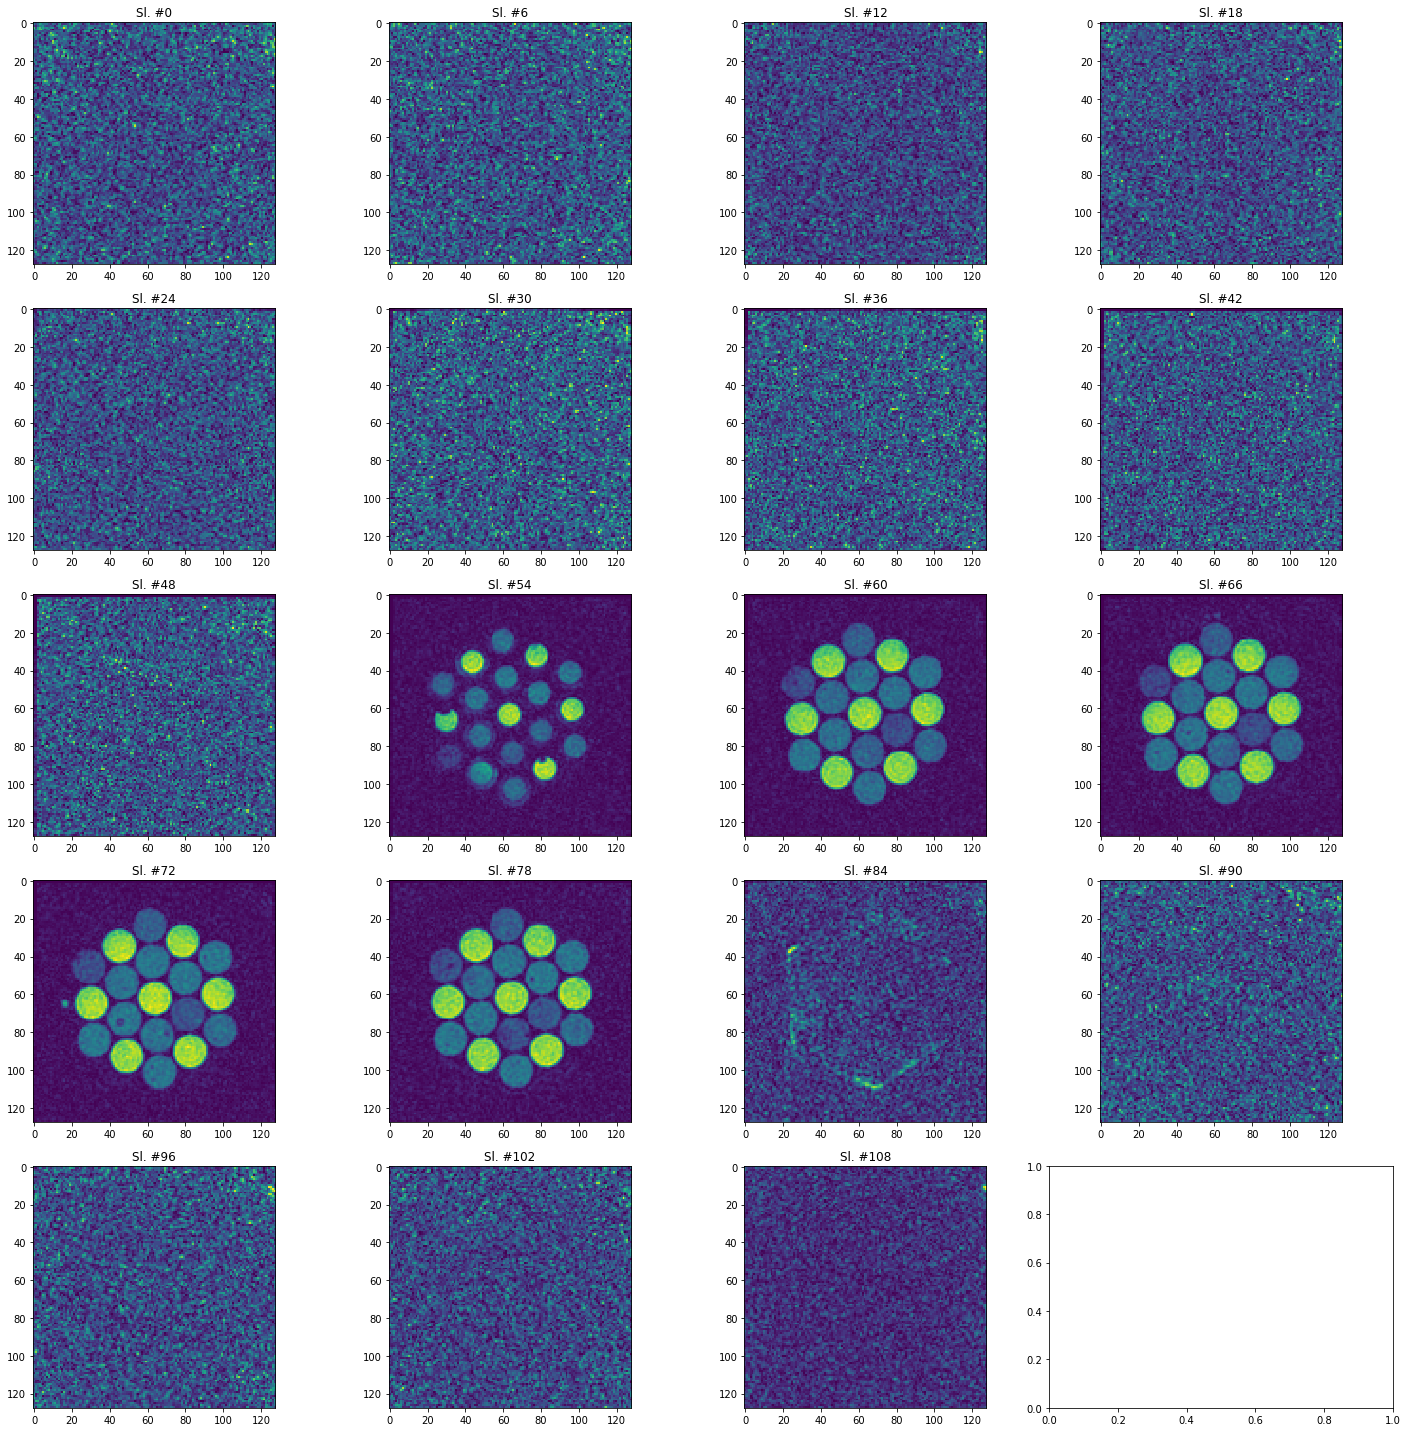

In [3]:
# plot a couple slices (sanity check)

plt.close()
plt.figure(figsize=(20.0, 20.0))

slices = np.arange(0, nz, np.ceil(nz/20), dtype=np.uint8)
#print((nx,ny,nz),axial_planes)
fig, ax = plt.subplots(5, 4, figsize=(20.0, 20.0))
for pl, zi in enumerate(slices):
    ai=ax[int(pl/4)][int(pl%4)]
    ai.imshow(vol[:,:,zi])
    ai.set_title('Sl. #{:d}'.format(zi))

fig.tight_layout()
fig.patch.set_facecolor('#ffffff')
plt.show()

fig.savefig('ia_rf1-20000.png')

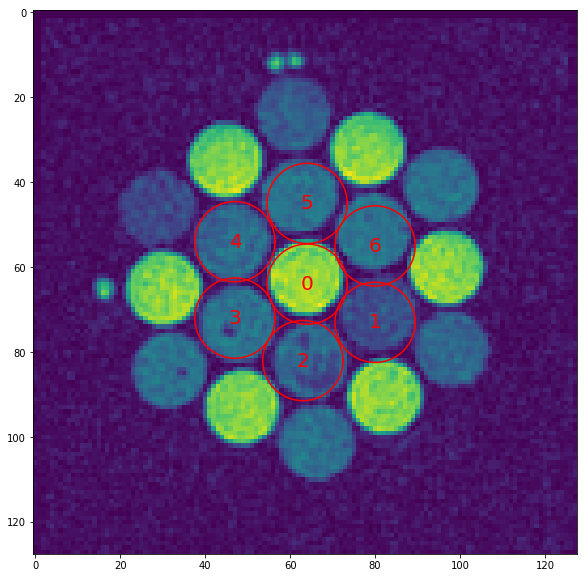

In [4]:
plt.close()
fig = plt.figure(figsize=(10.0, 10.0))

sli = 70
scl_slice = (vol[:,:,sli] - np.min(vol[:,:,sli]))/(np.max(vol[:,:,sli]) - np.min(vol[:,:,sli]))
plt.imshow(scl_slice)

rc = 13.5 # mm
cx0 = int(nx/2)
cy0 = int(ny/2)

#plt.plot(cx0, cy0, 'rx')
plt.text(cy0, cx0, '{:d}'.format(0), fontdict = {
    'color': 'red',
    'fontsize': 20,
    'horizontalalignment' : 'center',
    'verticalalignment' : 'center'
})
th = np.linspace(0.0, 2*np.pi, 100)
xx = rc/dx * np.cos(th) + cy0
yy = rc/dy * np.sin(th) + cx0
plt.plot(xx, yy, 'r')

dth = np.pi / 3.1
for ci in range(6):
    thi = dth - ci * np.pi / 3.0
    cx = int(((cx0 * dx) + (2 * rc * np.cos(thi)))/dx)
    cy = int(((cy0 * dy) + (2 * rc * np.sin(thi)))/dy)
    #plt.plot(cx, cy, 'rx')
    th = np.linspace(0.0, 2*np.pi, 100)
    xx = rc/dy * np.cos(th) + cy
    yy = rc/dx * np.sin(th) + cx
    plt.plot(xx, yy, 'r')
    plt.text(cy, cx, '{:d}'.format(ci+1), fontdict = {
        'color': 'red',
        'fontsize': 20,
        'horizontalalignment' : 'center',
        'verticalalignment' : 'center'
    })

plt.show()

fig.savefig('ia_rf1-20000_sl-{:d}.png'.format(sli))

Rotation cannot be performed automatically!


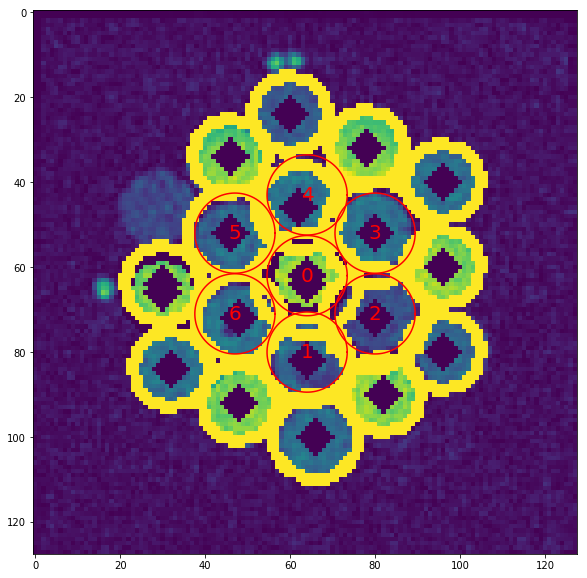

In [5]:
import cv2

# Automatically find proper rotation and translation params for ROIs.
# This uses a hough circle transform algorithm, and correctness should be
# visually verified below.
plt.close()

img = scl_slice*255.0
img = img.astype(np.uint8)
#img = cv2.medianBlur(img,5)

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,20,
                            param1=50,param2=30,minRadius=int(rc-10),maxRadius=int(rc))
circles = np.uint16(np.around(circles))

retval, image = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)
target_circles = cv2.HoughCircles(image,cv2.HOUGH_GRADIENT,1,5,
                            param1=50,param2=10,minRadius=int(rc-5),maxRadius=int(rc))
target_circles = np.uint16(np.around(target_circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(img,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
    
for i in target_circles[0,:]:
    # draw the outer circle
    cv2.circle(img,(i[0],i[1]),i[2],(255,255,0),2)
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(0,0,255),3)
    

fig = plt.figure(figsize=(10.0, 10.0))

# Initial parameters:
cx0 = int(nx/2)
cy0 = int(ny/2)
# dth = np.pi / 6
dth = 0.0

# Central ROI circle assumed to be closest to initial param center:
try:
    circle_coords = circles[0,:]
    idx = (np.abs( np.square(circle_coords[:,0]-cx0) + np.square(circle_coords[:,1]-cy0) )).argmin()
    center_circle = circle_coords[idx]
    cx0 = center_circle[1]
    cy0 = center_circle[0]
except:
    raise Exception('No ROIs detected... stopping.')
    
centX = cx0
centY = cy0


# Now automatically ROTATE ROIs using target capsules (if visible):
if (len(target_circles[0,:]) == 3):
    targ_coords = target_circles[0,:]
    min_centers = [] # indices of two circles that are close to one another.
    min_dist = sys.maxsize
    for i in range(len(targ_coords)): # efficient since len = 3
        for j in range(len(targ_coords)):
            if (i != j):
                dx2 = float(targ_coords[i,0]) - float(targ_coords[j,0])
                dy2 = float(targ_coords[i,1]) - float(targ_coords[j,1])
                dist = np.square(dx2) + np.square(dy2)
                if (dist<min_dist):
                    min_dist = dist
                    indices = [i,j]
                    cent = np.array([(targ_coords[i,0],targ_coords[i,1]),(targ_coords[j,0],targ_coords[j,1])])
    
    # find coordinate of midpoint between smaller circles:
    two_midX = min(cent[0,0],cent[1,0]) + abs((int(cent[0,0]) - int(cent[1,0]))//2)
    two_midY = min(cent[0,1],cent[1,1]) + abs((int(cent[0,1]) - int(cent[1,1]))//2)
    # find coord of third circle:
    index = [n for n in [0,1,2] if n not in indices][0]
    singleX = targ_coords[index,0]
    singleY = targ_coords[index,1]  
    
    y_diff = centY - two_midY
    x_diff = two_midX - centX
    print(y_diff, x_diff)
    dth = np.tan(y_diff / x_diff)
else:
    print("Rotation cannot be performed automatically!")




# Continue by plotting:
plt.text(cy0, cx0, '{:d}'.format(0), fontdict = {
    'color': 'red',
    'fontsize': 20,
    'horizontalalignment' : 'center',
    'verticalalignment' : 'center'
})
th = np.linspace(0.0, 2*np.pi, 100)
xx = rc/dx * np.cos(th) + cy0
yy = rc/dy * np.sin(th) + cx0
plt.plot(xx, yy, 'r')

for ci in range(6):
    thi = dth + ci * np.pi / 3.0
    cx = int(((cx0 * dx) + (2 * rc * np.cos(thi)))/dx)
    cy = int(((cy0 * dy) + (2 * rc * np.sin(thi)))/dy)
    #plt.plot(cx, cy, 'rx')
    th = np.linspace(0.0, 2*np.pi, 100)
    xx = rc/dy * np.cos(th) + cy
    yy = rc/dx * np.sin(th) + cx
    plt.plot(xx, yy, 'r')
    plt.text(cy, cx, '{:d}'.format(ci+1), fontdict = {
        'color': 'red',
        'fontsize': 20,
        'horizontalalignment' : 'center',
        'verticalalignment' : 'center'
    })
    

plt.imshow(img)
plt.show()

In [6]:
# Create ROIs for quantification

sys.path.append('/home/dharshan/Code/Work/UCSF-qMRI/qmri-toolbox')
from pyqmri.phantom_util import roi

# *** set up some ROI dimensions based on physical measurements *** #

# Container dimensions
n_c = 19                  # number of containers
rc = 14 # Container radius (mm)
hc = 95.25/2 # Container height (mm) NOTE: outer dimensions

# *** Initialize ROIs based on geometry *** #
# ROI size
roi_ht = hc * 0.5
roi_rd = rc * 0.25

# Approximate planes for cylinder centers
cz = 70.0 * dz # based on approximate center of containers in slice direction (see above)

# Image center
im_cx = int(nx/2) * dx
im_cy = int(ny/2) * dy
im_cz = int(nz/2) * dz


# *** CONTAINER CONFIGURATION ***
roi_labels = [
    '0: (W02) Water + 0.5% wt. CuSO4',
    '1: (W04) Water + 0.1% wt. CuSO4',
    '2: (W05) Water + 0.2% wt. CuSO4',
    '3: (W06) Water + 0.4% wt. CuSO4',
    '4: (W07) Water + 0.8% wt. CuSO4',
    '5: (W08) Water + 1.6% wt. CuSO4',
    '6: (W09) Water + 3.2% wt. CuSO4',
    '7: (B02.1) Plaster + 0.5% wt. CuSO4',
    '8: (B02.2) Plaster + 0.5% wt. CuSO4',
    '9: (B01.1) Undoped Plaster',
    '10: (B01.2) Undoped Plaster',
    '11: (B08.1) Plaster + 4.0% wt. CuSO4',
    '12: (B08.2) Plaster + 4.0% wt. CuSO4',
    '13: (B07.1) Plaster + 2.0% wt. CuSO4',
    '14: (B07.2) Plaster + 2.0% wt. CuSO4',
    '15: (B06.1) Plaster + 0.25% wt. CuSO4',
    '16: (B06.2) Plaster + 0.25% wt. CuSO4',
    '17: (B04.1) Plaster + 1.0% wt. CuSO4',
    '18: (B04.2) Plaster + 1.0% wt. CuSO4'
]

roi_info = []

cx0 = centX * dx
cy0 = centY * dy
th0 = 30.0 * (np.pi / 180.0)

roi_info.append({}) # C10 [0]
roi_info[0]['cx'] = cx0
roi_info[0]['cy'] = cy0
roi_info[0]['cz'] = cz

roi_info[0]['ht'] = roi_ht
roi_info[0]['rd'] = roi_rd

roi_info[0]['mask'] = roi.CylinderROI(
    roi_info[0]['cx'],
    roi_info[0]['cy'],
    roi_info[0]['cz'],
    roi_info[0]['ht'],
    roi_info[0]['rd']
).generate_mask(nx, ny, nz, dx, dy, dz)
roi_info[0]['label'] = roi_labels[0]

for ci in range(1, 7):
    thi = th0 - ((ci - 1) * np.pi / 3.0)
    del_cx = 2 * (2 * rc * np.cos(np.pi/6.0)) * np.cos(thi)
    del_cy = 2 * (2 * rc * np.cos(np.pi/6.0)) * np.sin(thi)
    
    roi_info.append({})
    roi_info[ci]['cx'] = cx0 + del_cx
    roi_info[ci]['cy'] = cy0 + del_cy
    roi_info[ci]['cz'] = cz
    
    roi_info[ci]['ht'] = roi_ht
    roi_info[ci]['rd'] = roi_rd
    
    roi_info[ci]['mask'] = roi.CylinderROI(
        roi_info[ci]['cx'],
        roi_info[ci]['cy'],
        roi_info[ci]['cz'],
        roi_info[ci]['ht'],
        roi_info[ci]['rd']
    ).generate_mask(nx, ny, nz, dx, dy, dz)
    
    roi_info[ci]['label'] = roi_labels[ci]

th1 = 0.0 * (np.pi / 180.0)
for ci in range(7, n_c):
    c1 = ci - 7
    if (c1 % 2 == 0):
        thi = np.pi + th1 - np.floor(c1/2) * np.pi / 3.0
        del_cx = 2 * rc * np.cos(thi)
        del_cy = 2 * rc * np.sin(thi)
    else:
        thi = th1 - np.floor(c1/2) * np.pi / 3.0
        del_cx = 4 * rc * np.cos(thi)
        del_cy = 4 * rc * np.sin(thi)

    roi_info.append({})
    roi_info[ci]['cx'] = cx0 + del_cx
    roi_info[ci]['cy'] = cy0 + del_cy
    roi_info[ci]['cz'] = cz
    
    roi_info[ci]['ht'] = roi_ht
    roi_info[ci]['rd'] = roi_rd
    
    roi_info[ci]['mask'] = roi.CylinderROI(
        roi_info[ci]['cx'],
        roi_info[ci]['cy'],
        roi_info[ci]['cz'],
        roi_info[ci]['ht'],
        roi_info[ci]['rd']
    ).generate_mask(nx, ny, nz, dx, dy, dz)
    
    roi_info[ci]['label'] = roi_labels[ci]

#print(roi_info)

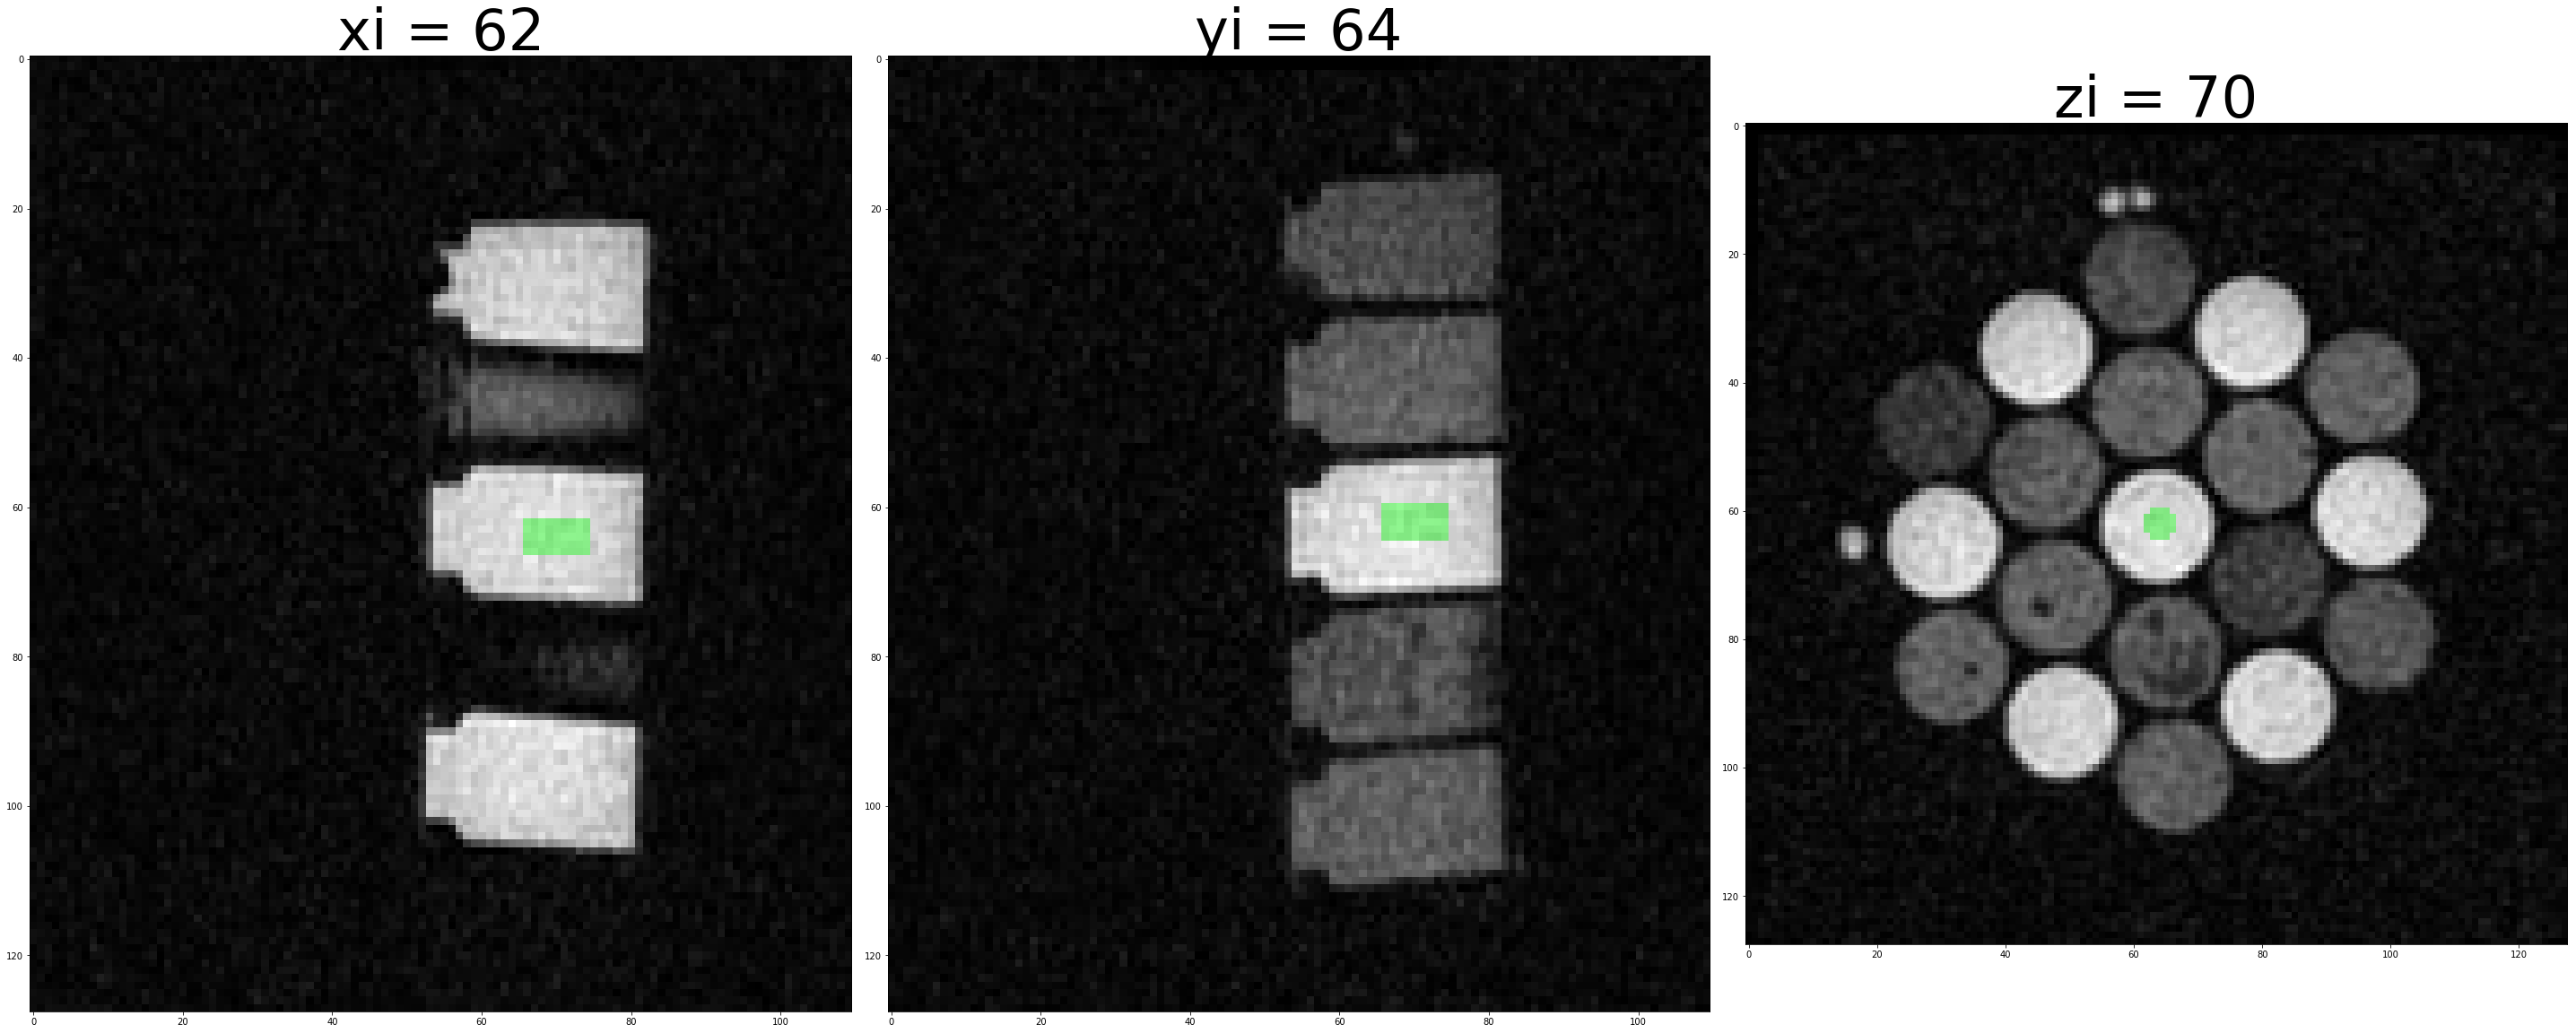

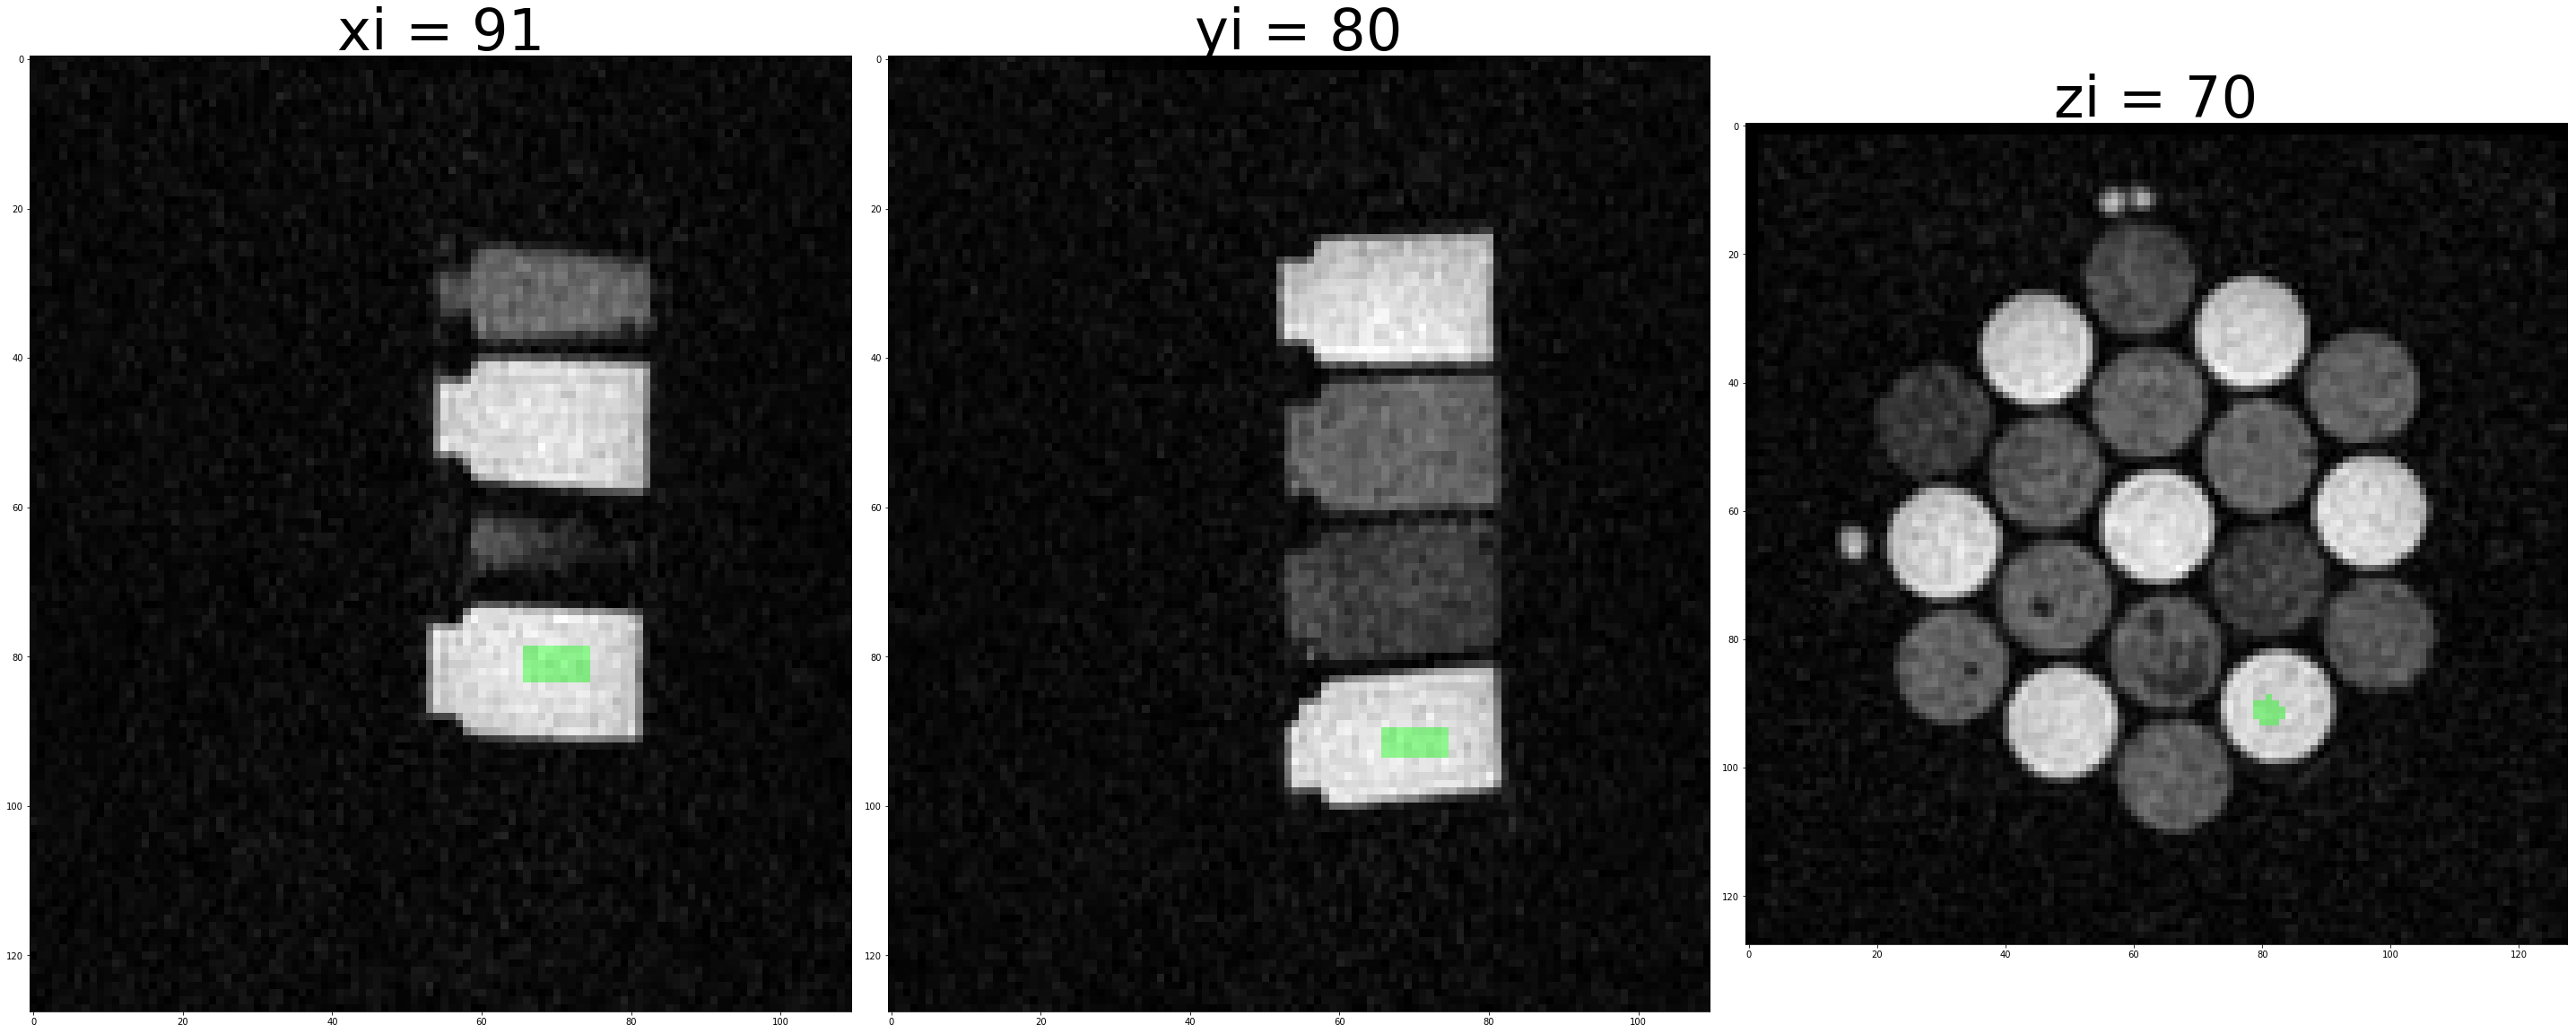

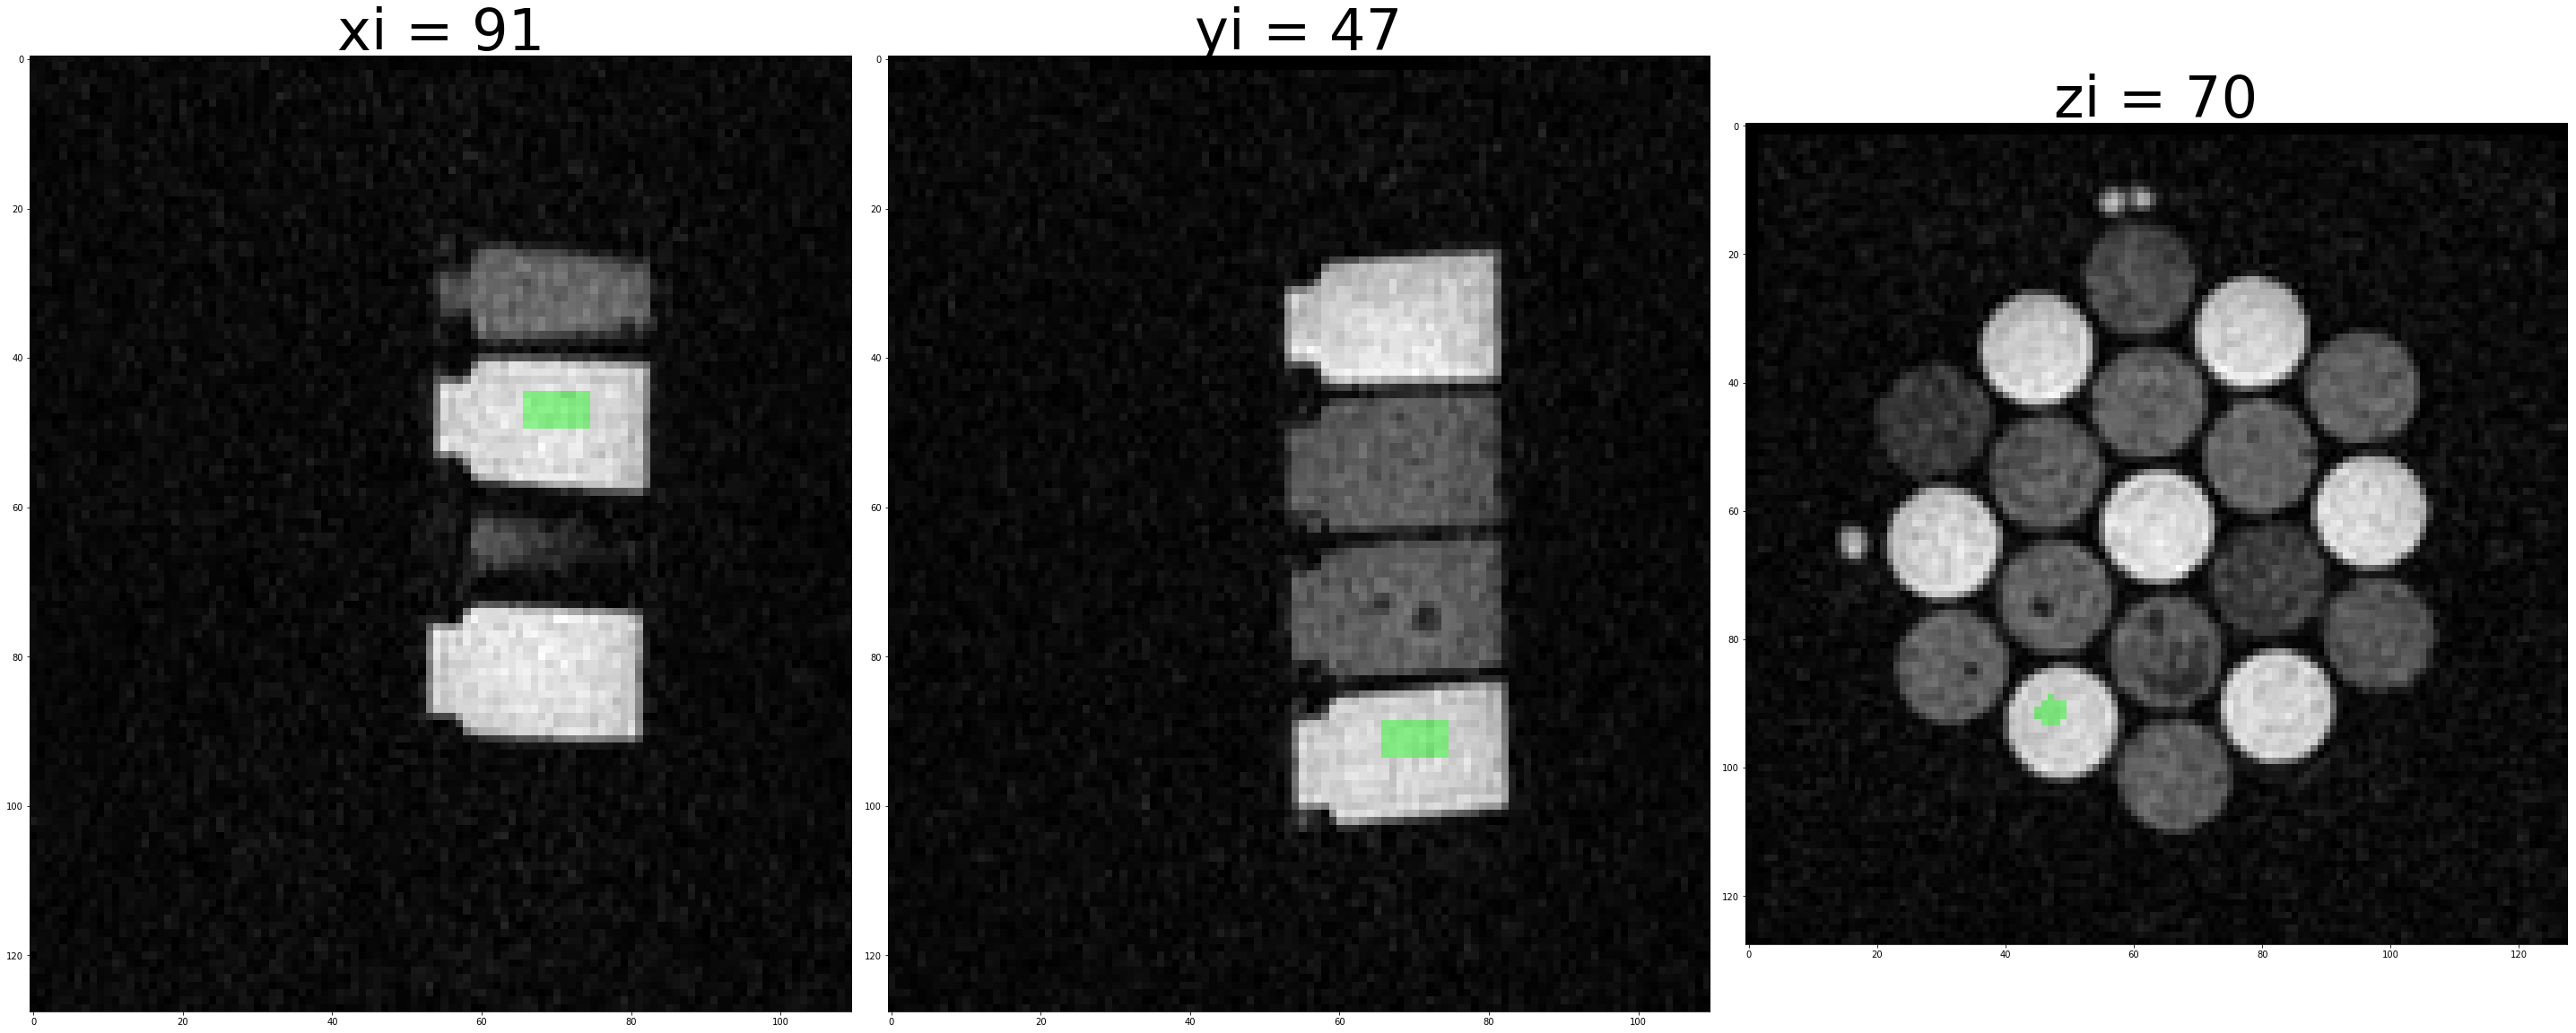

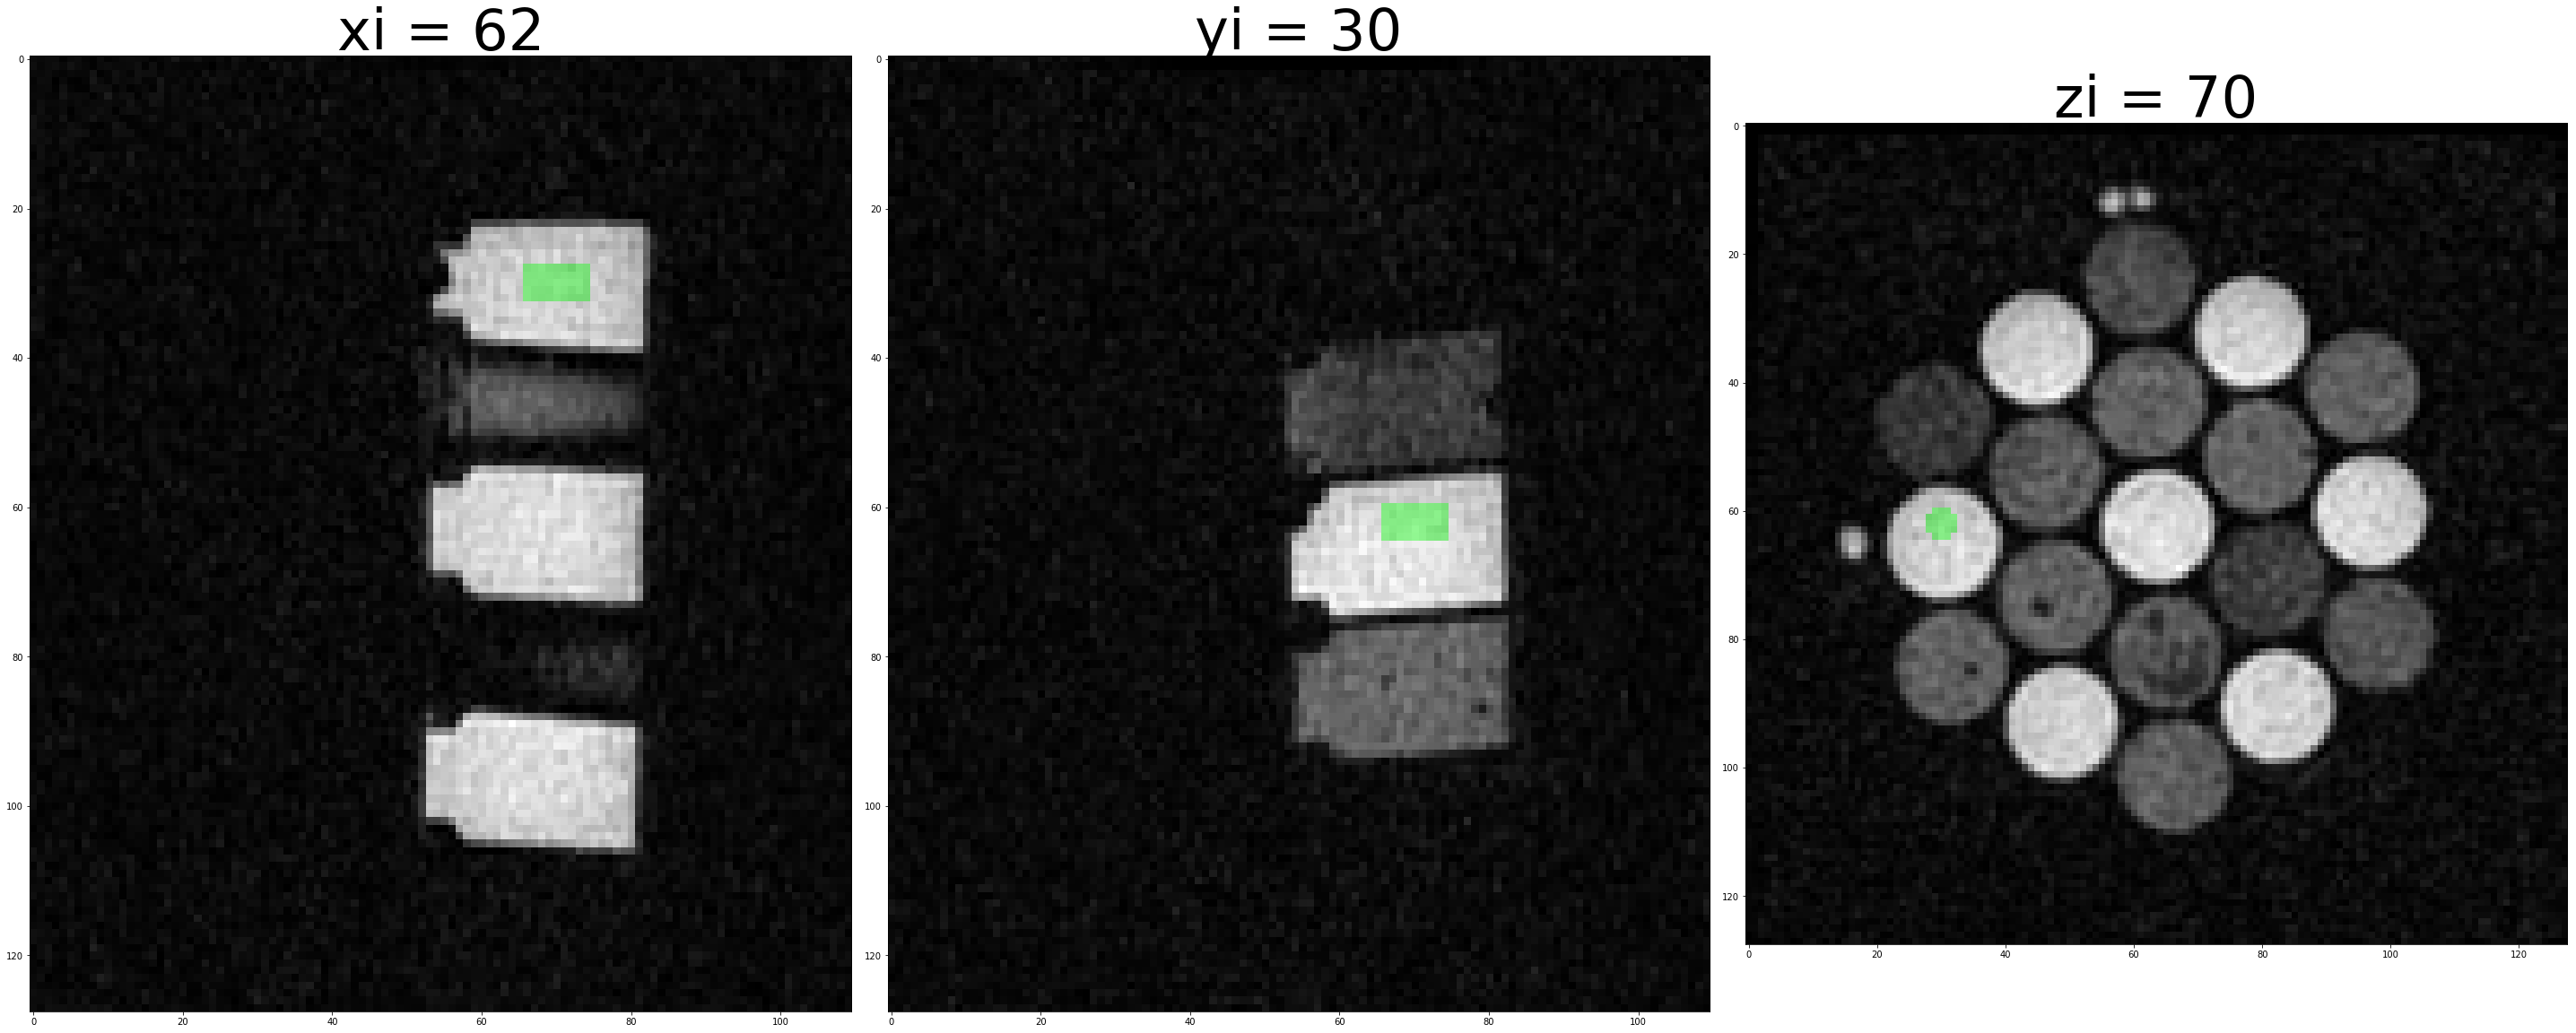

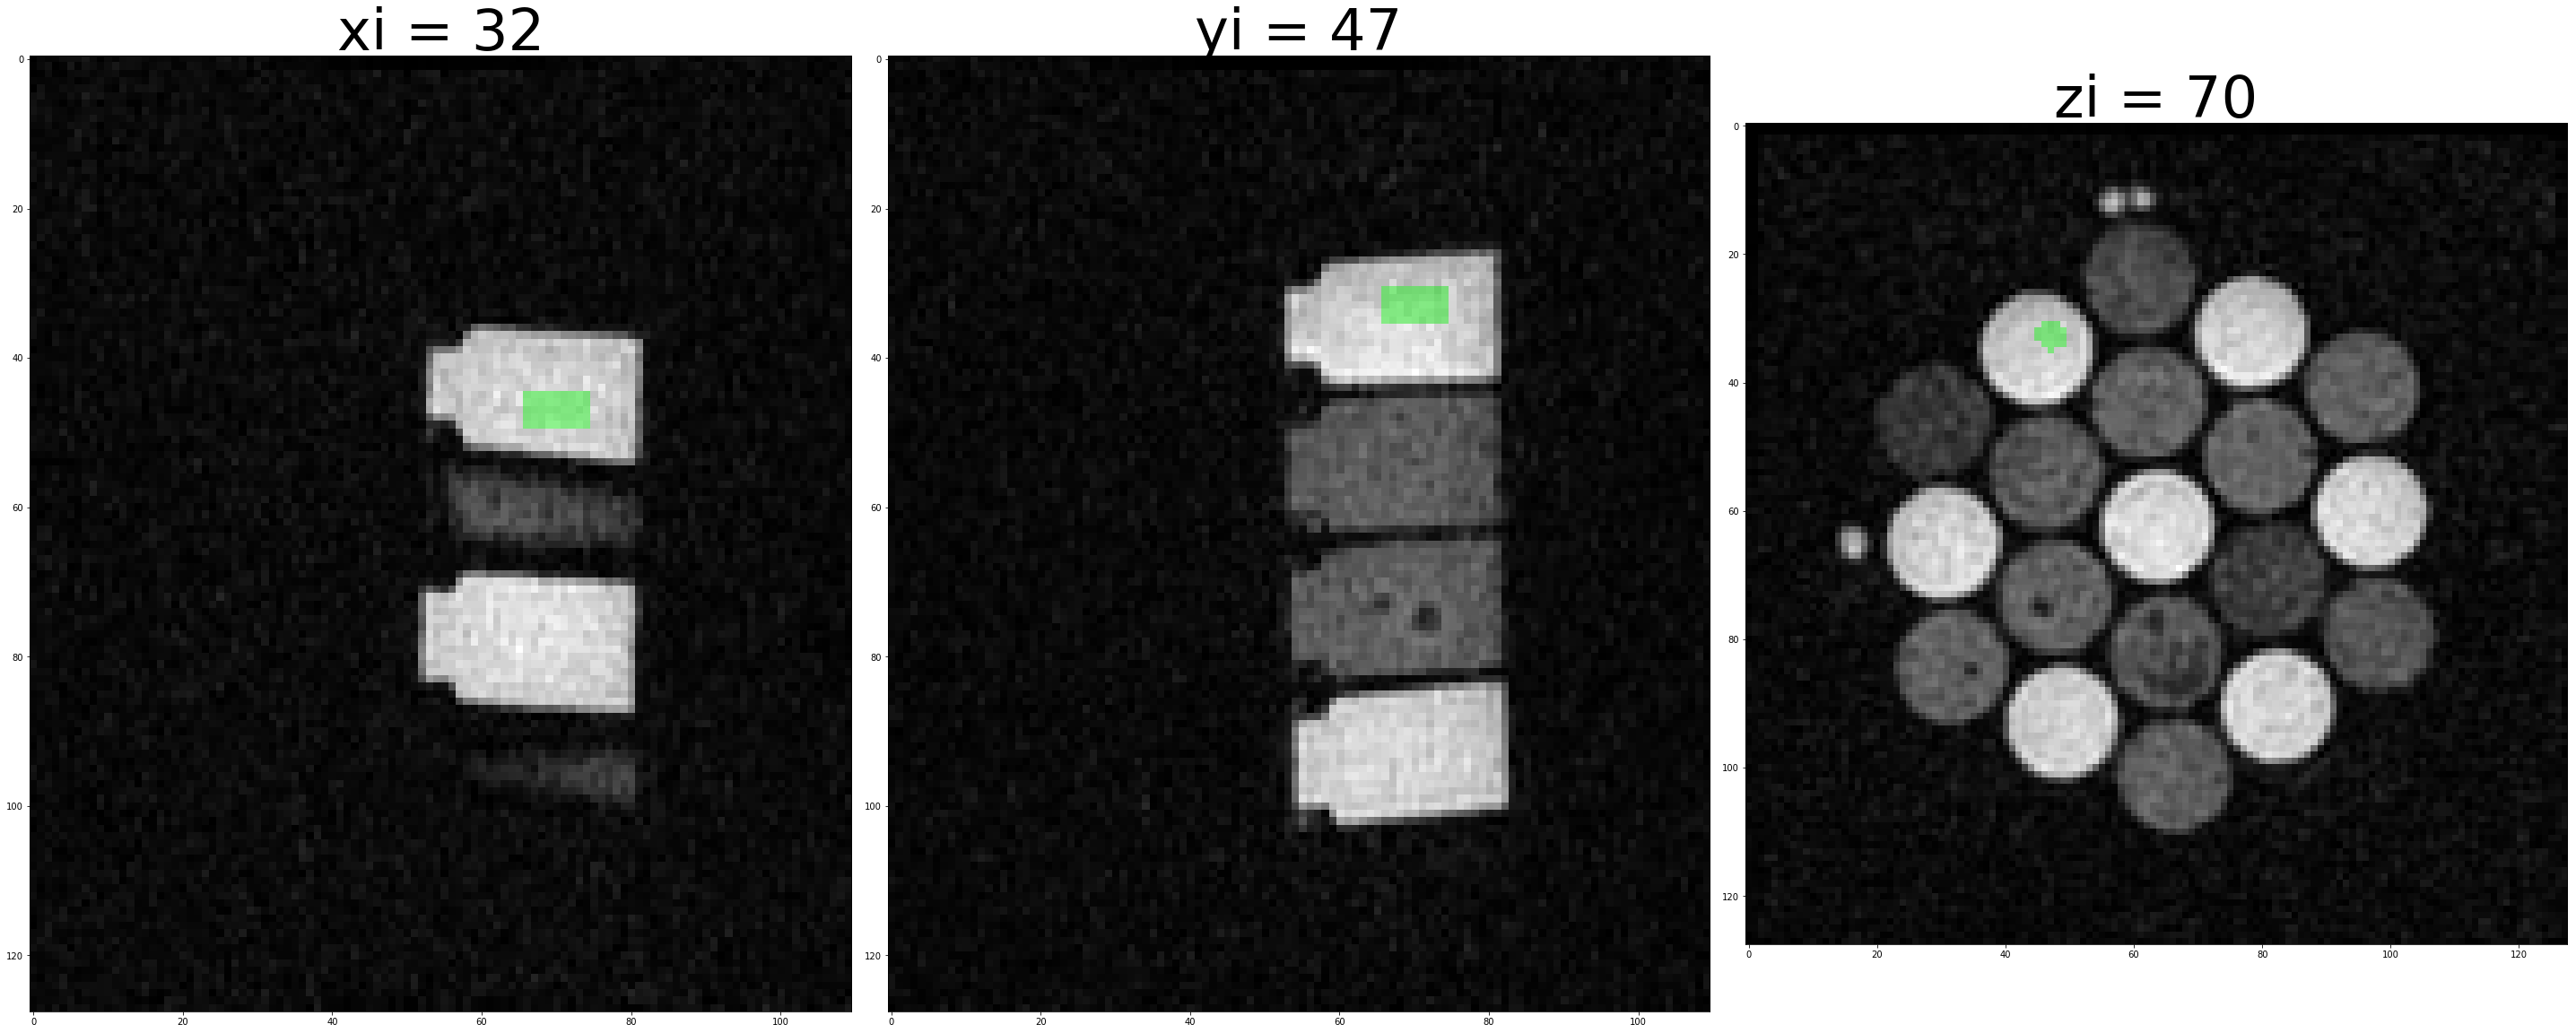

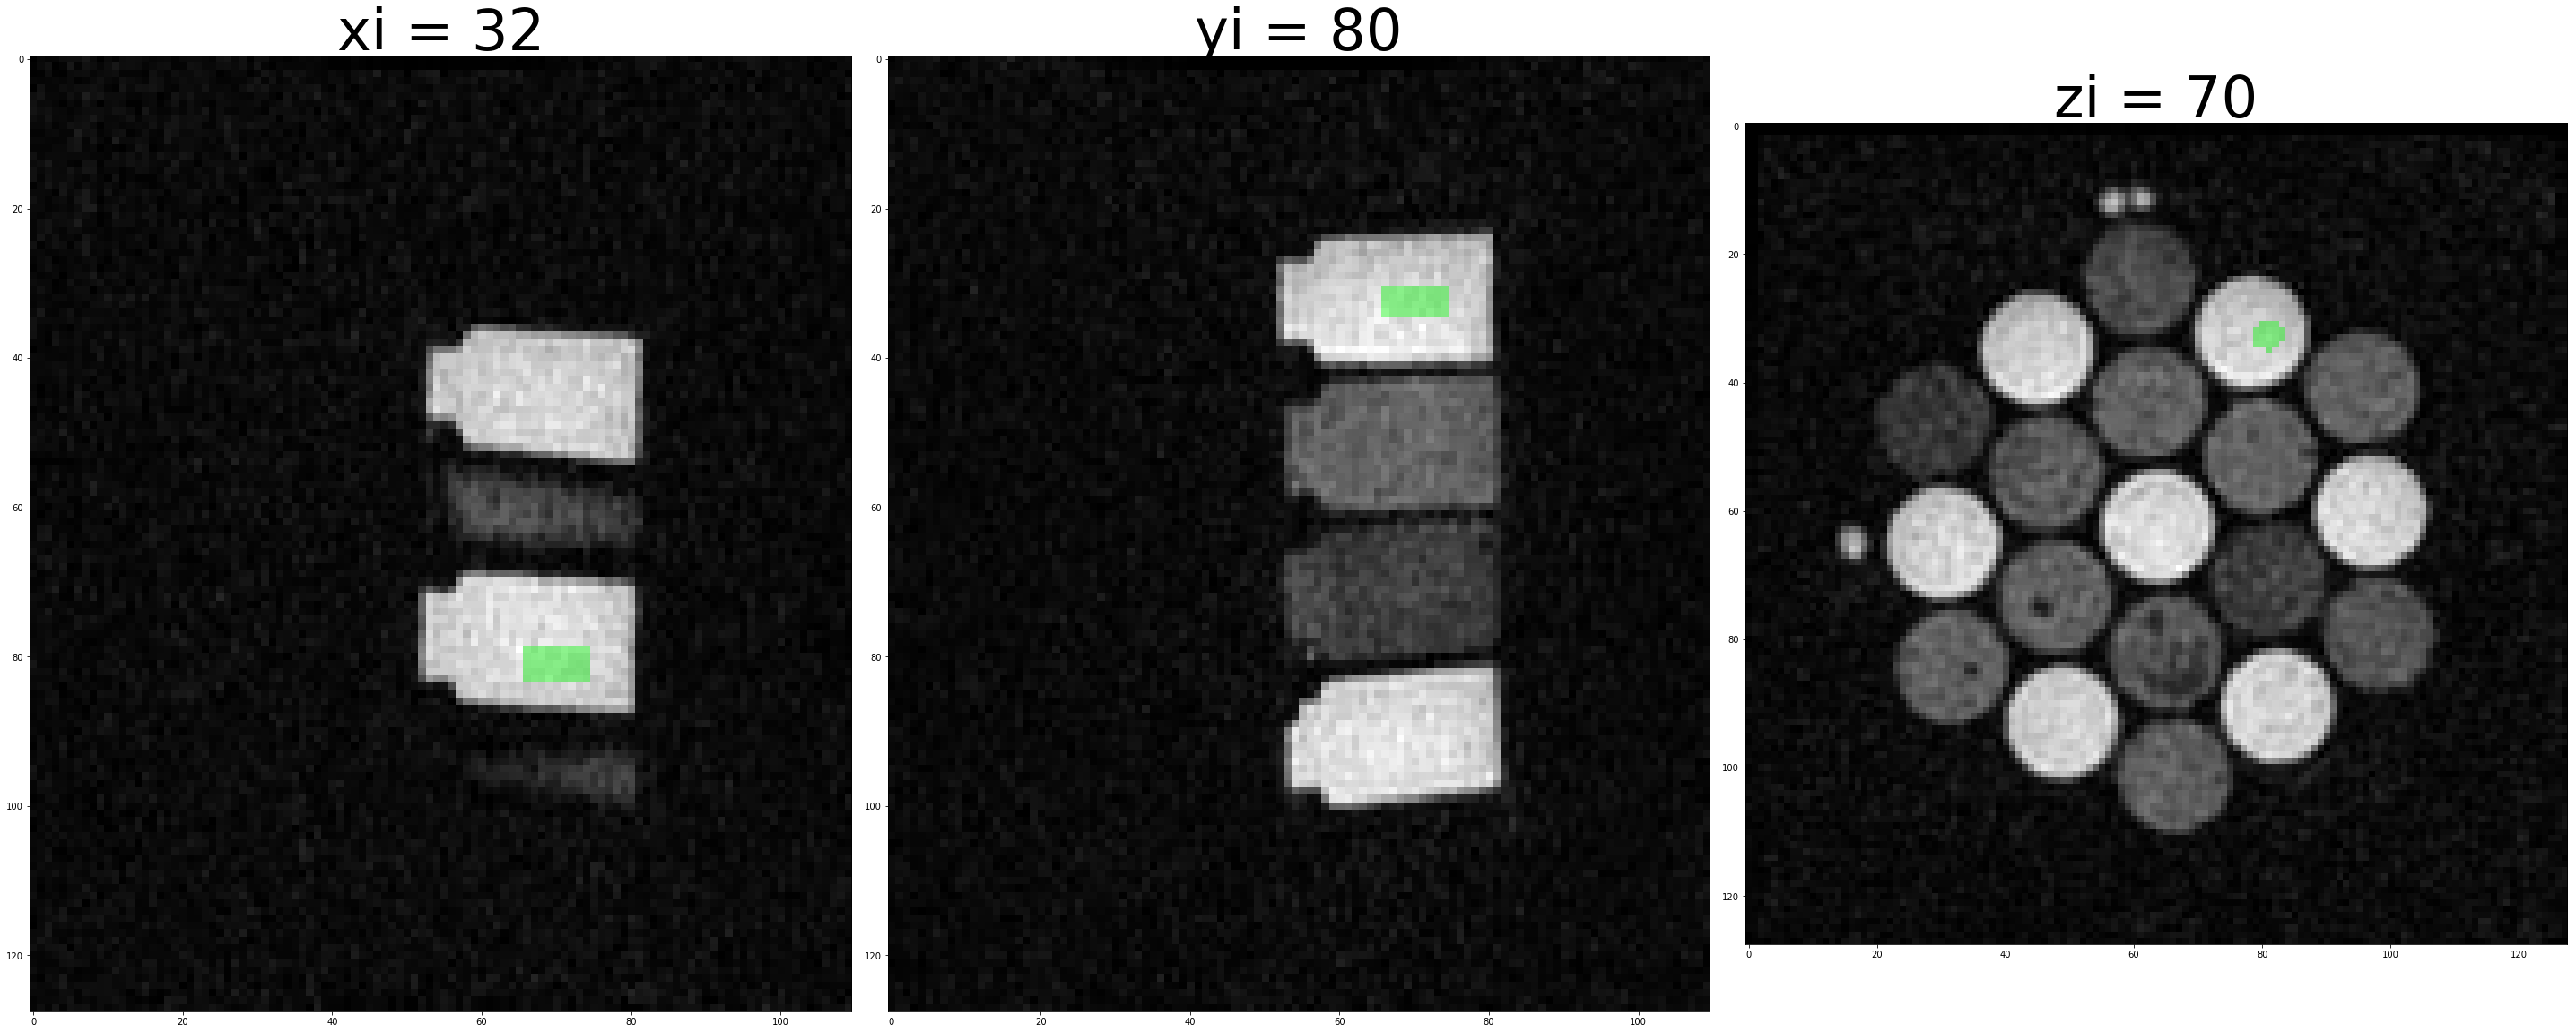

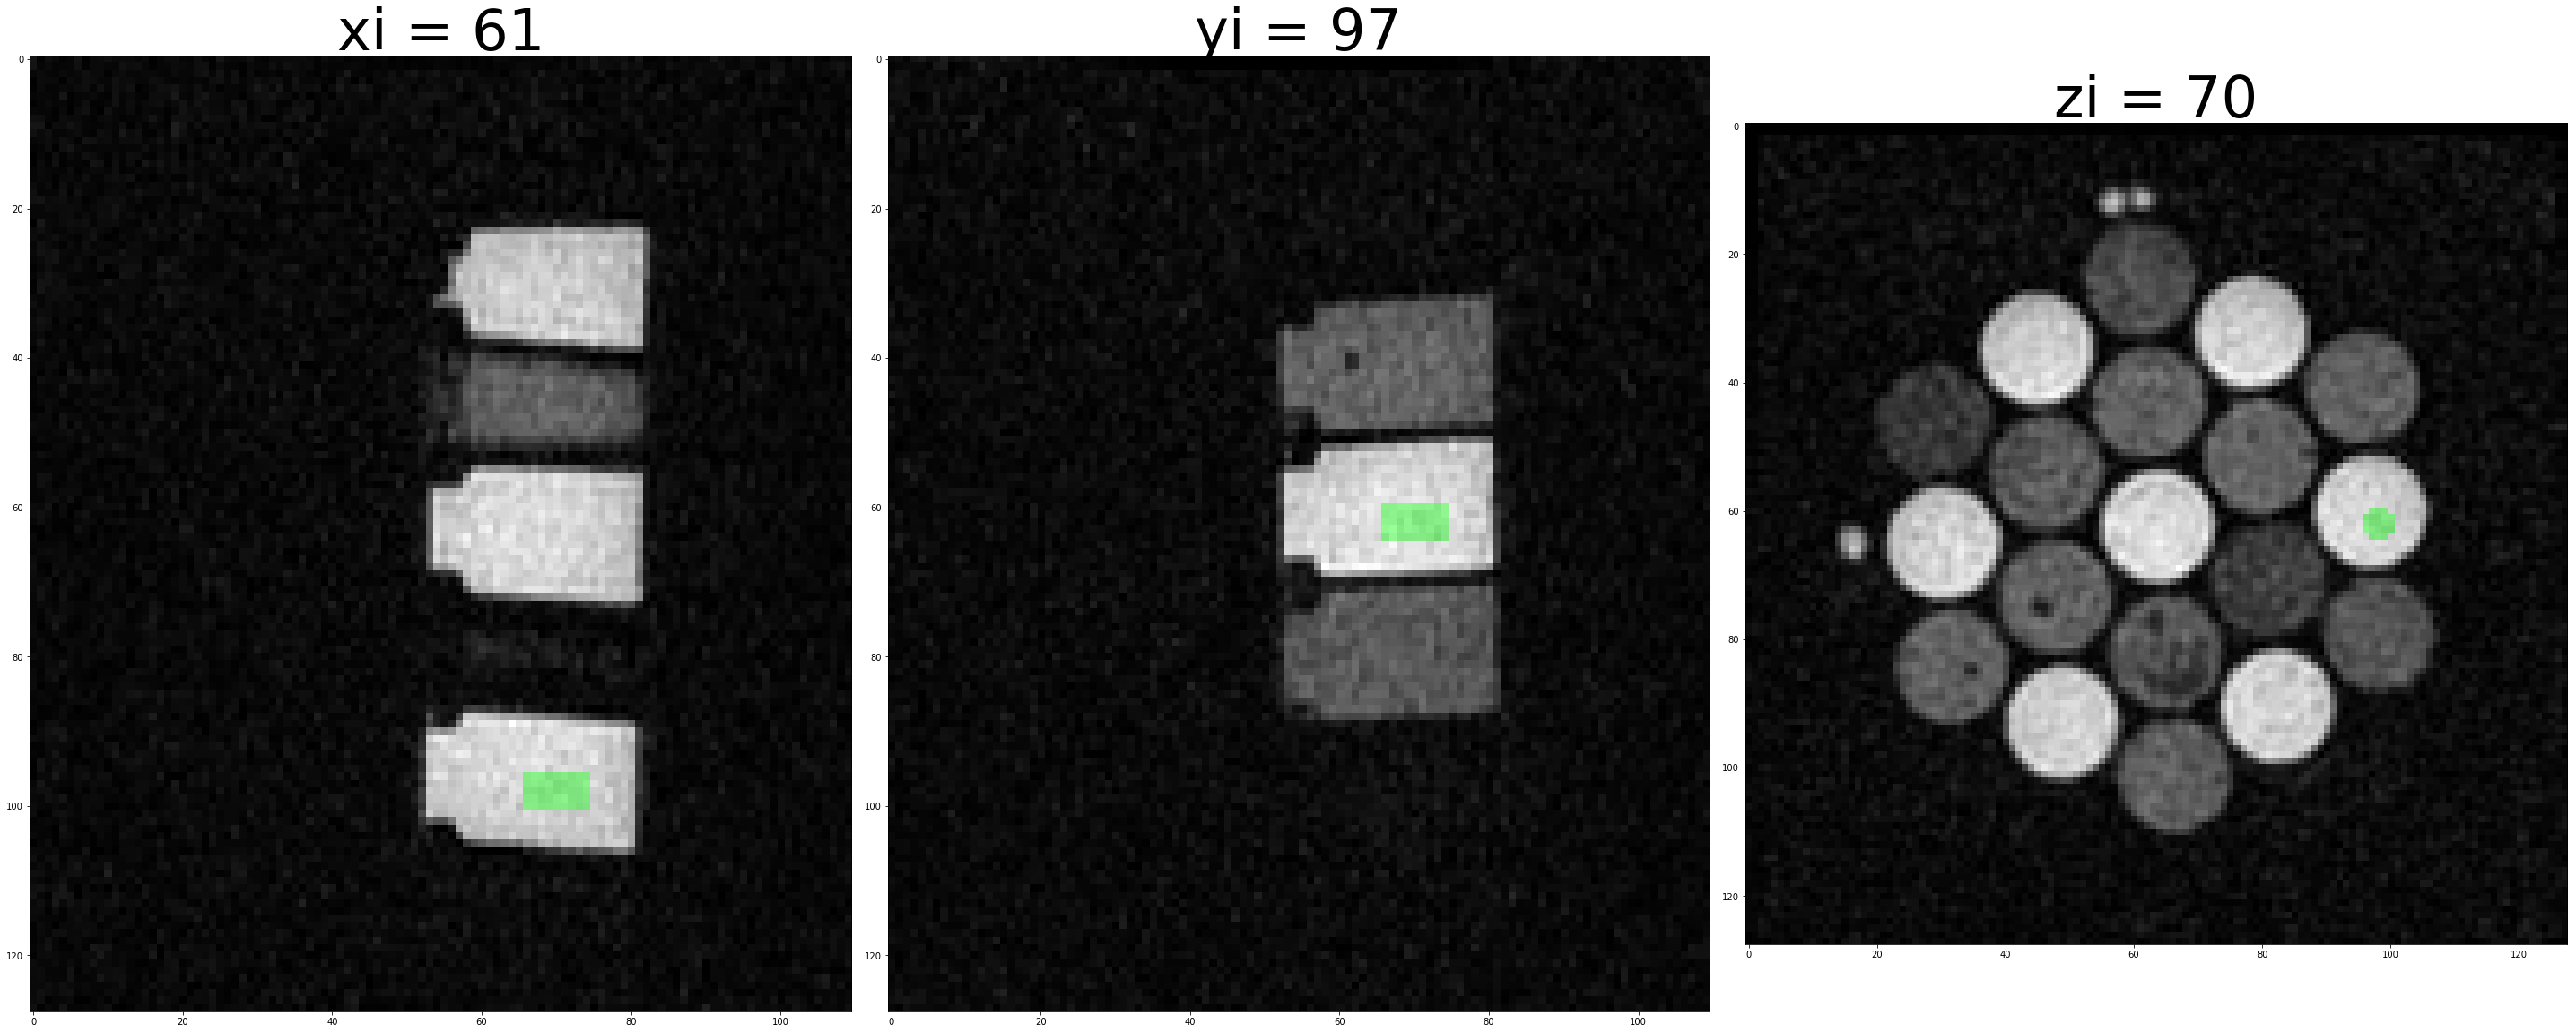

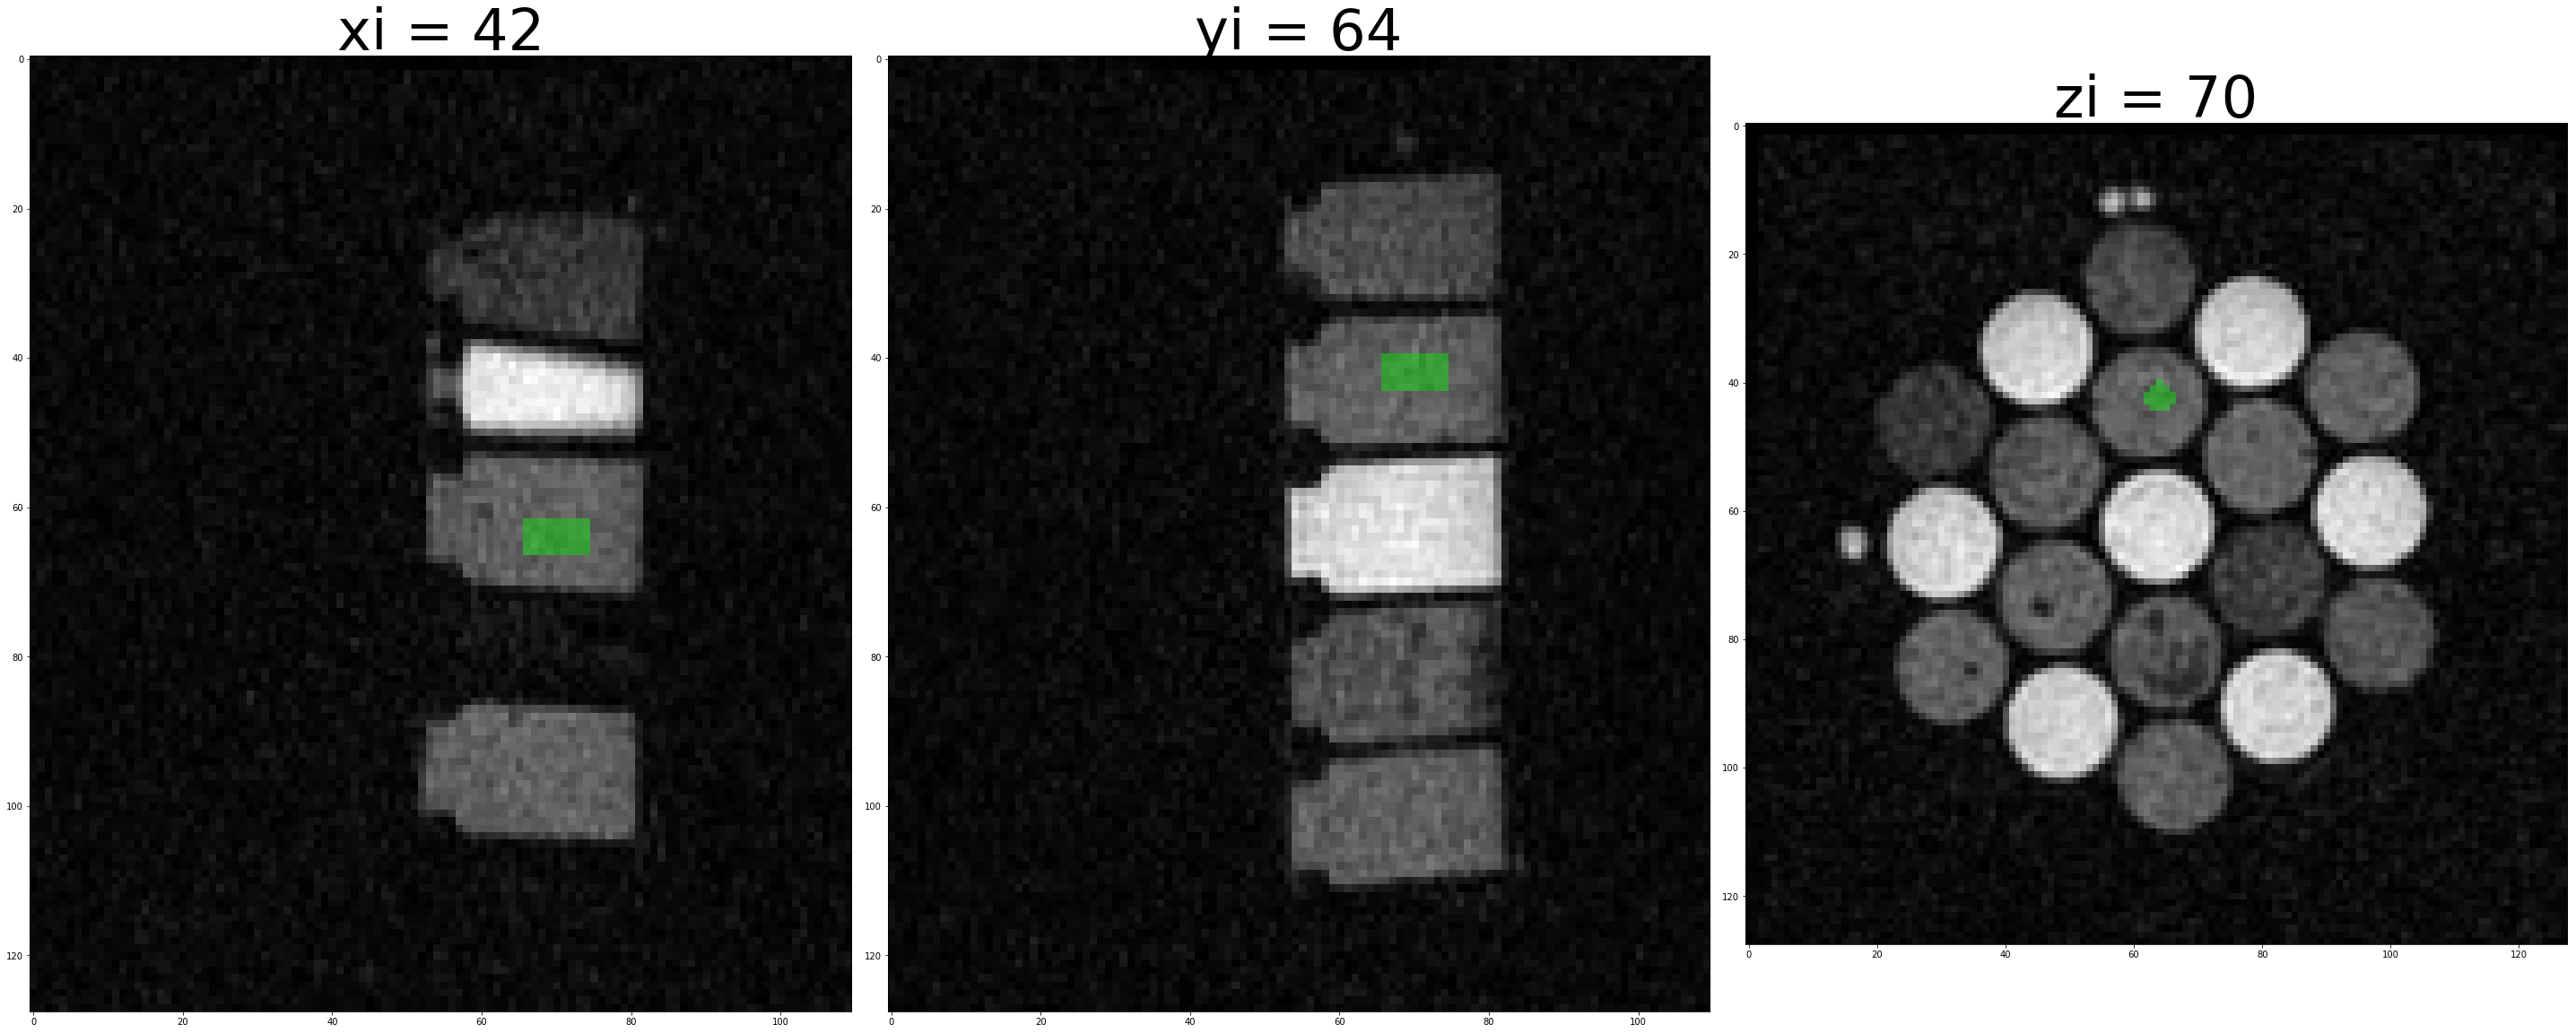

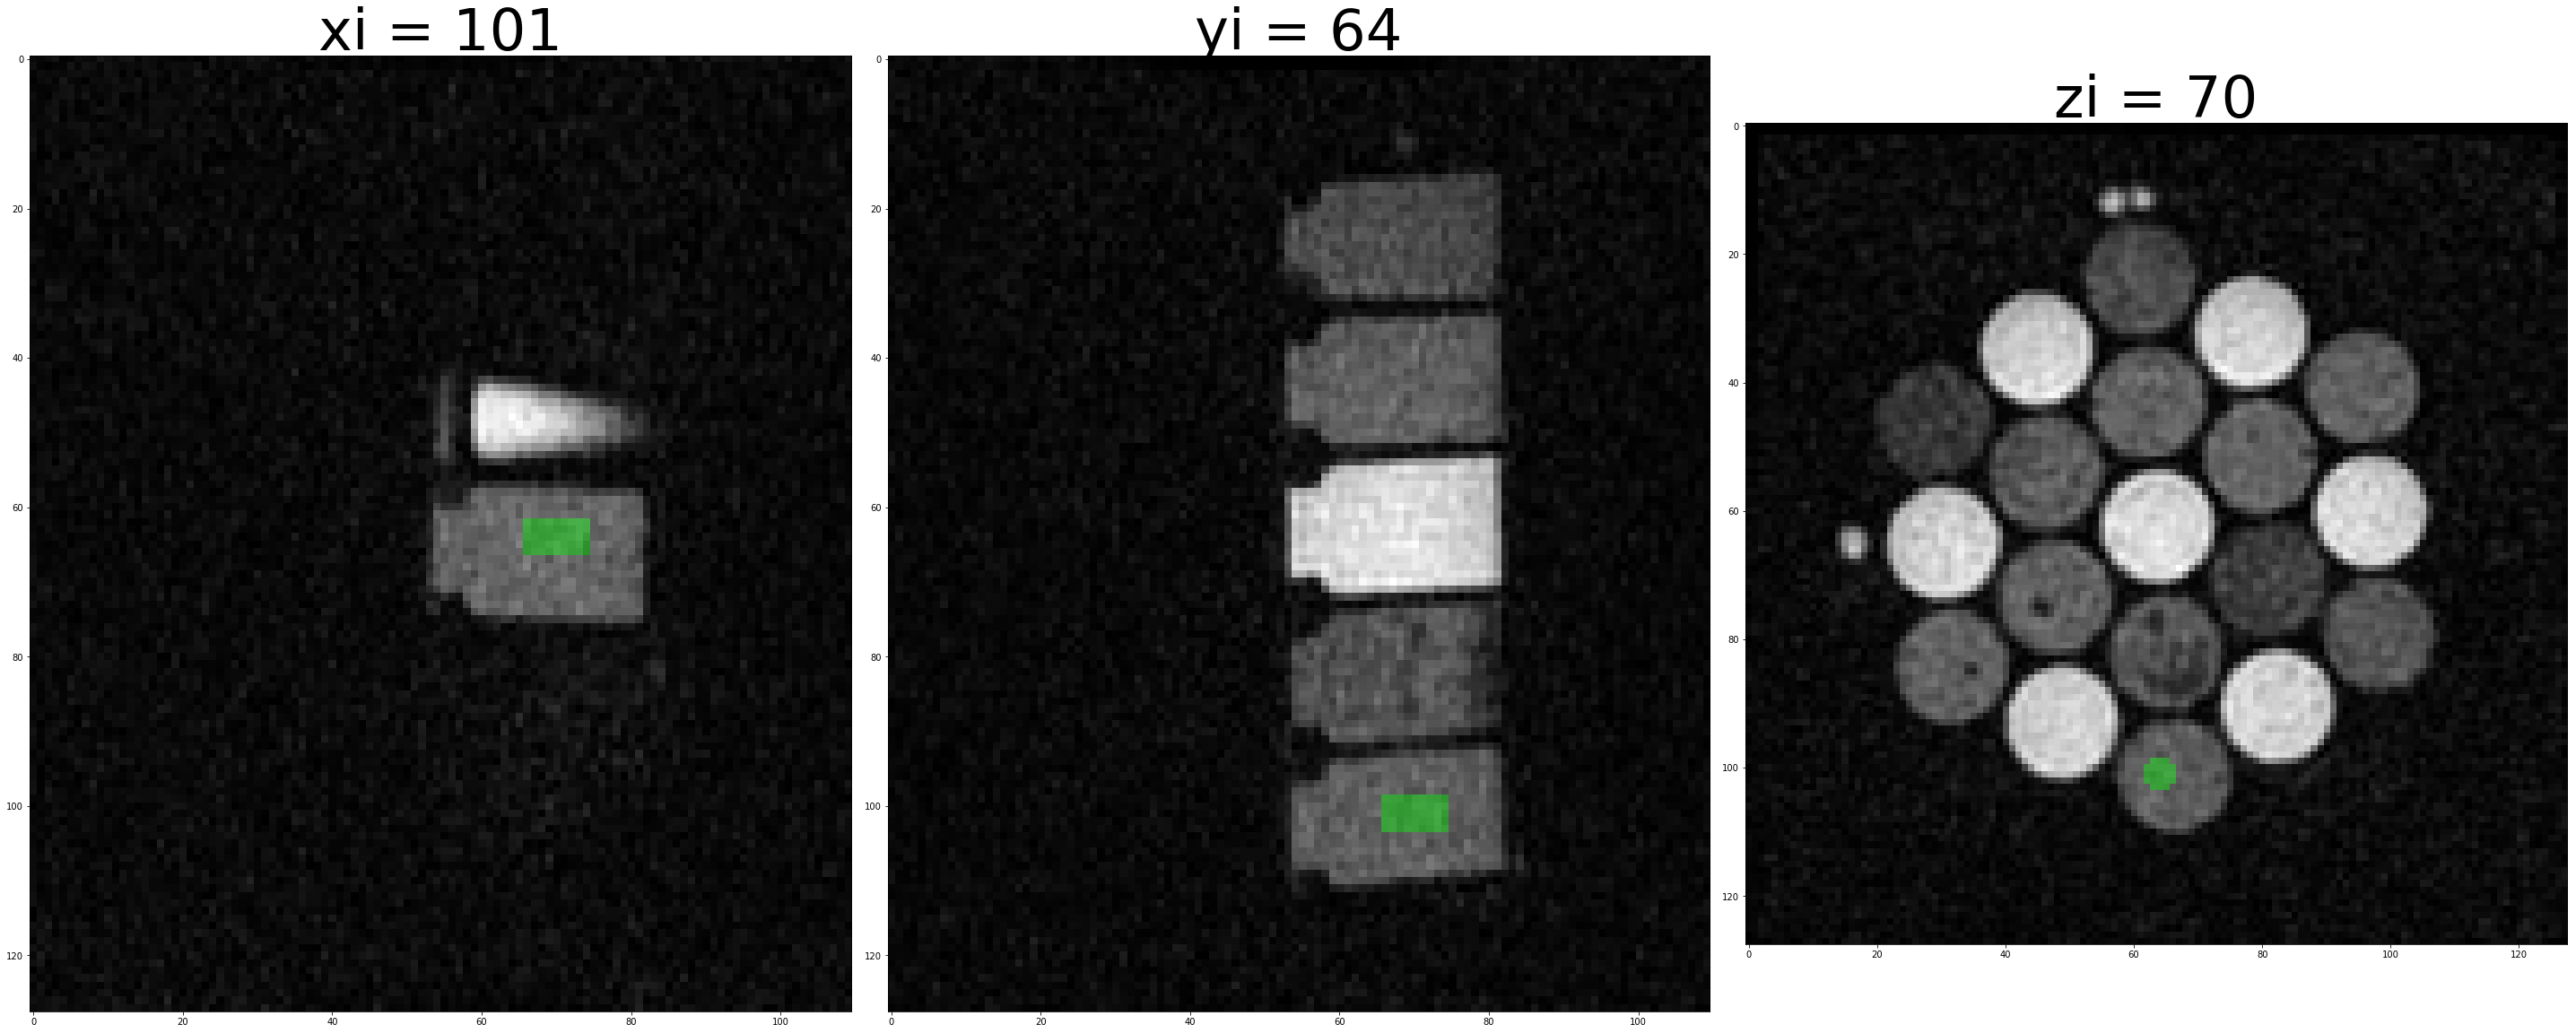

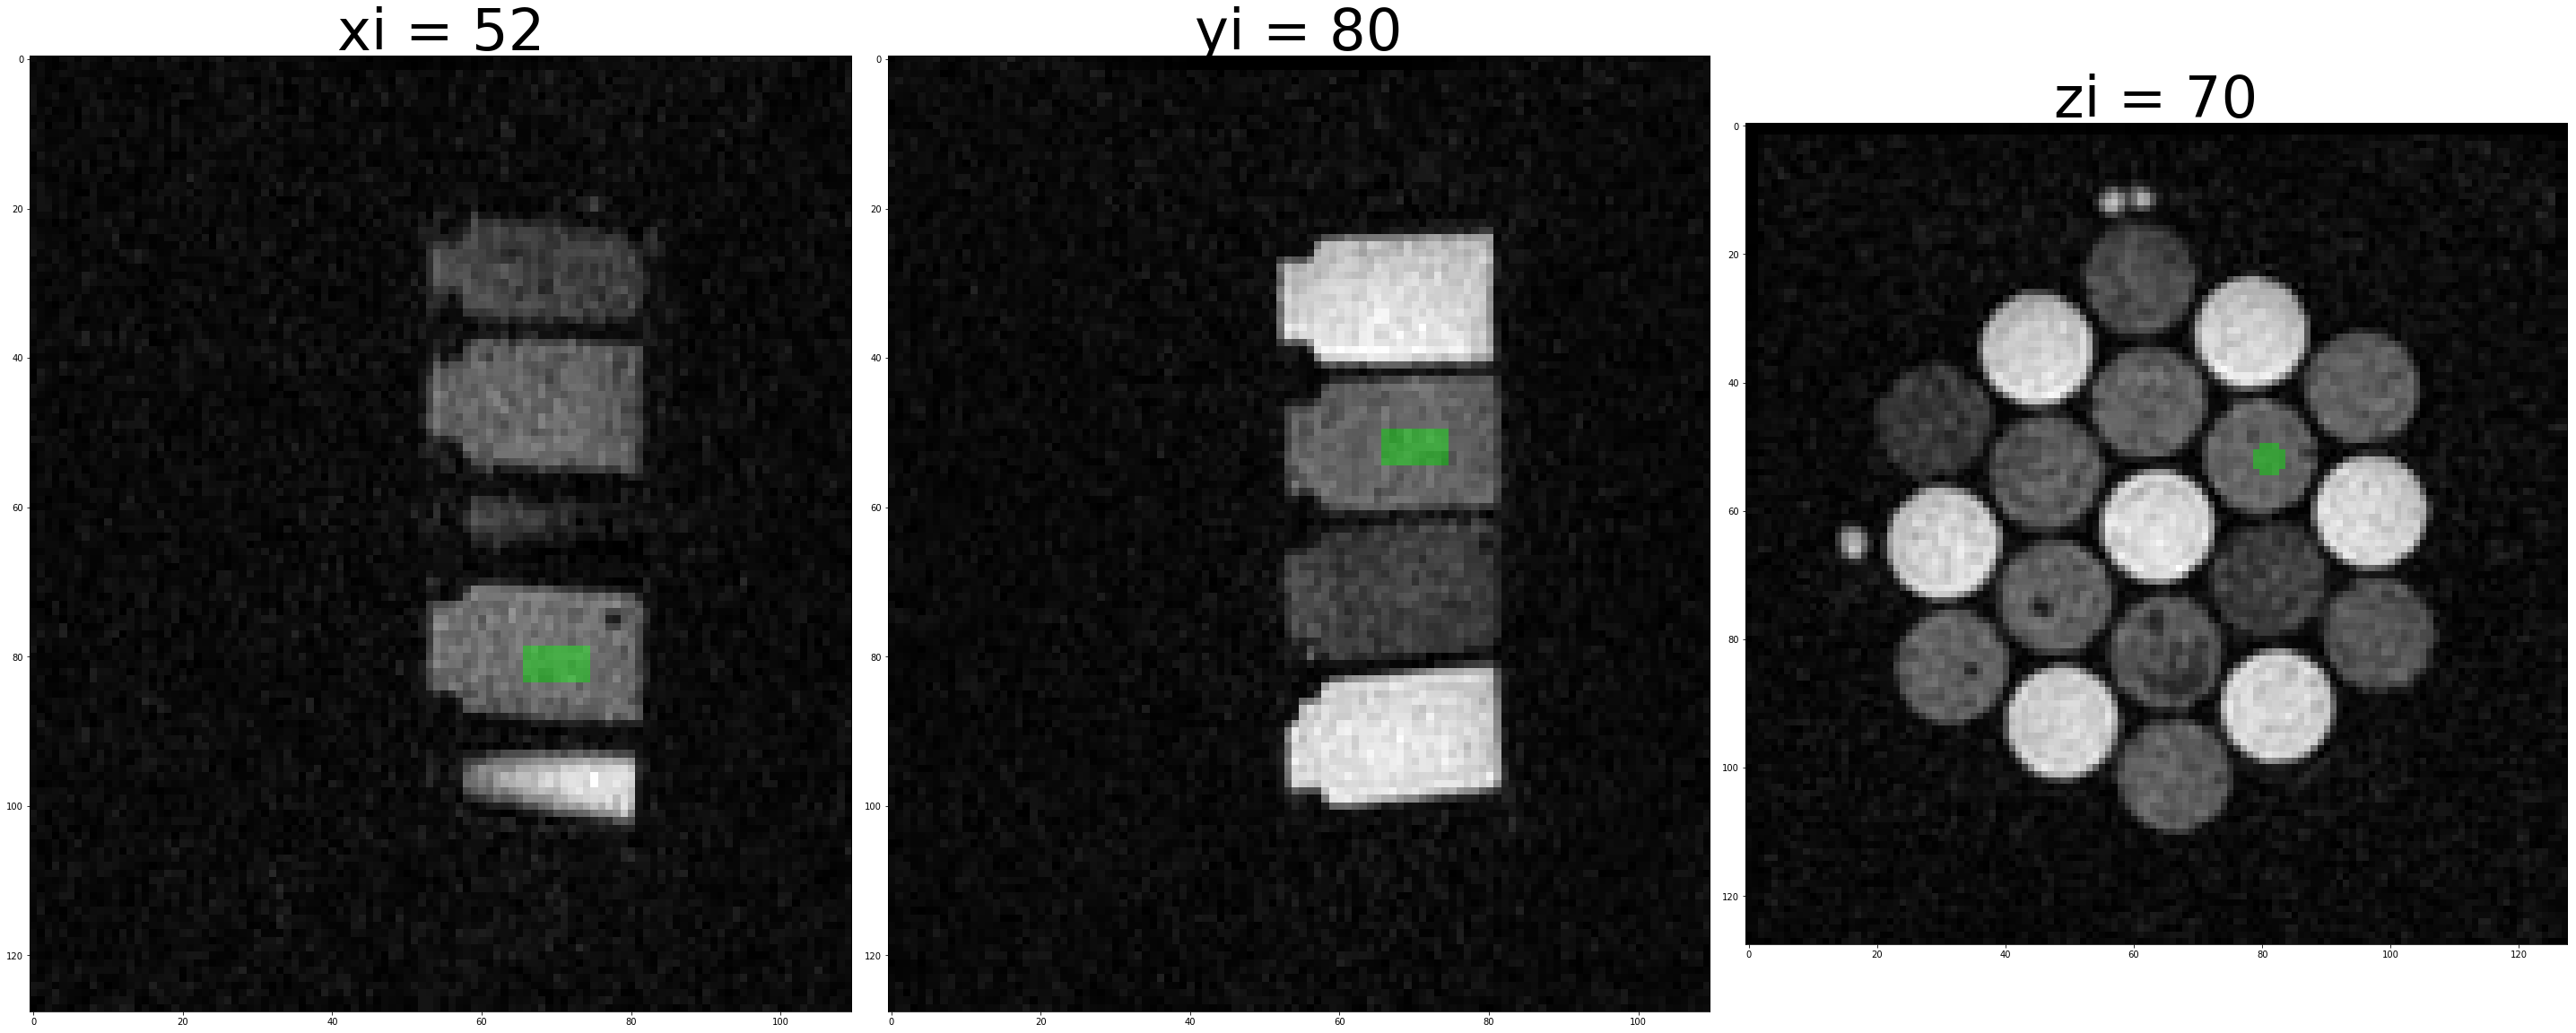

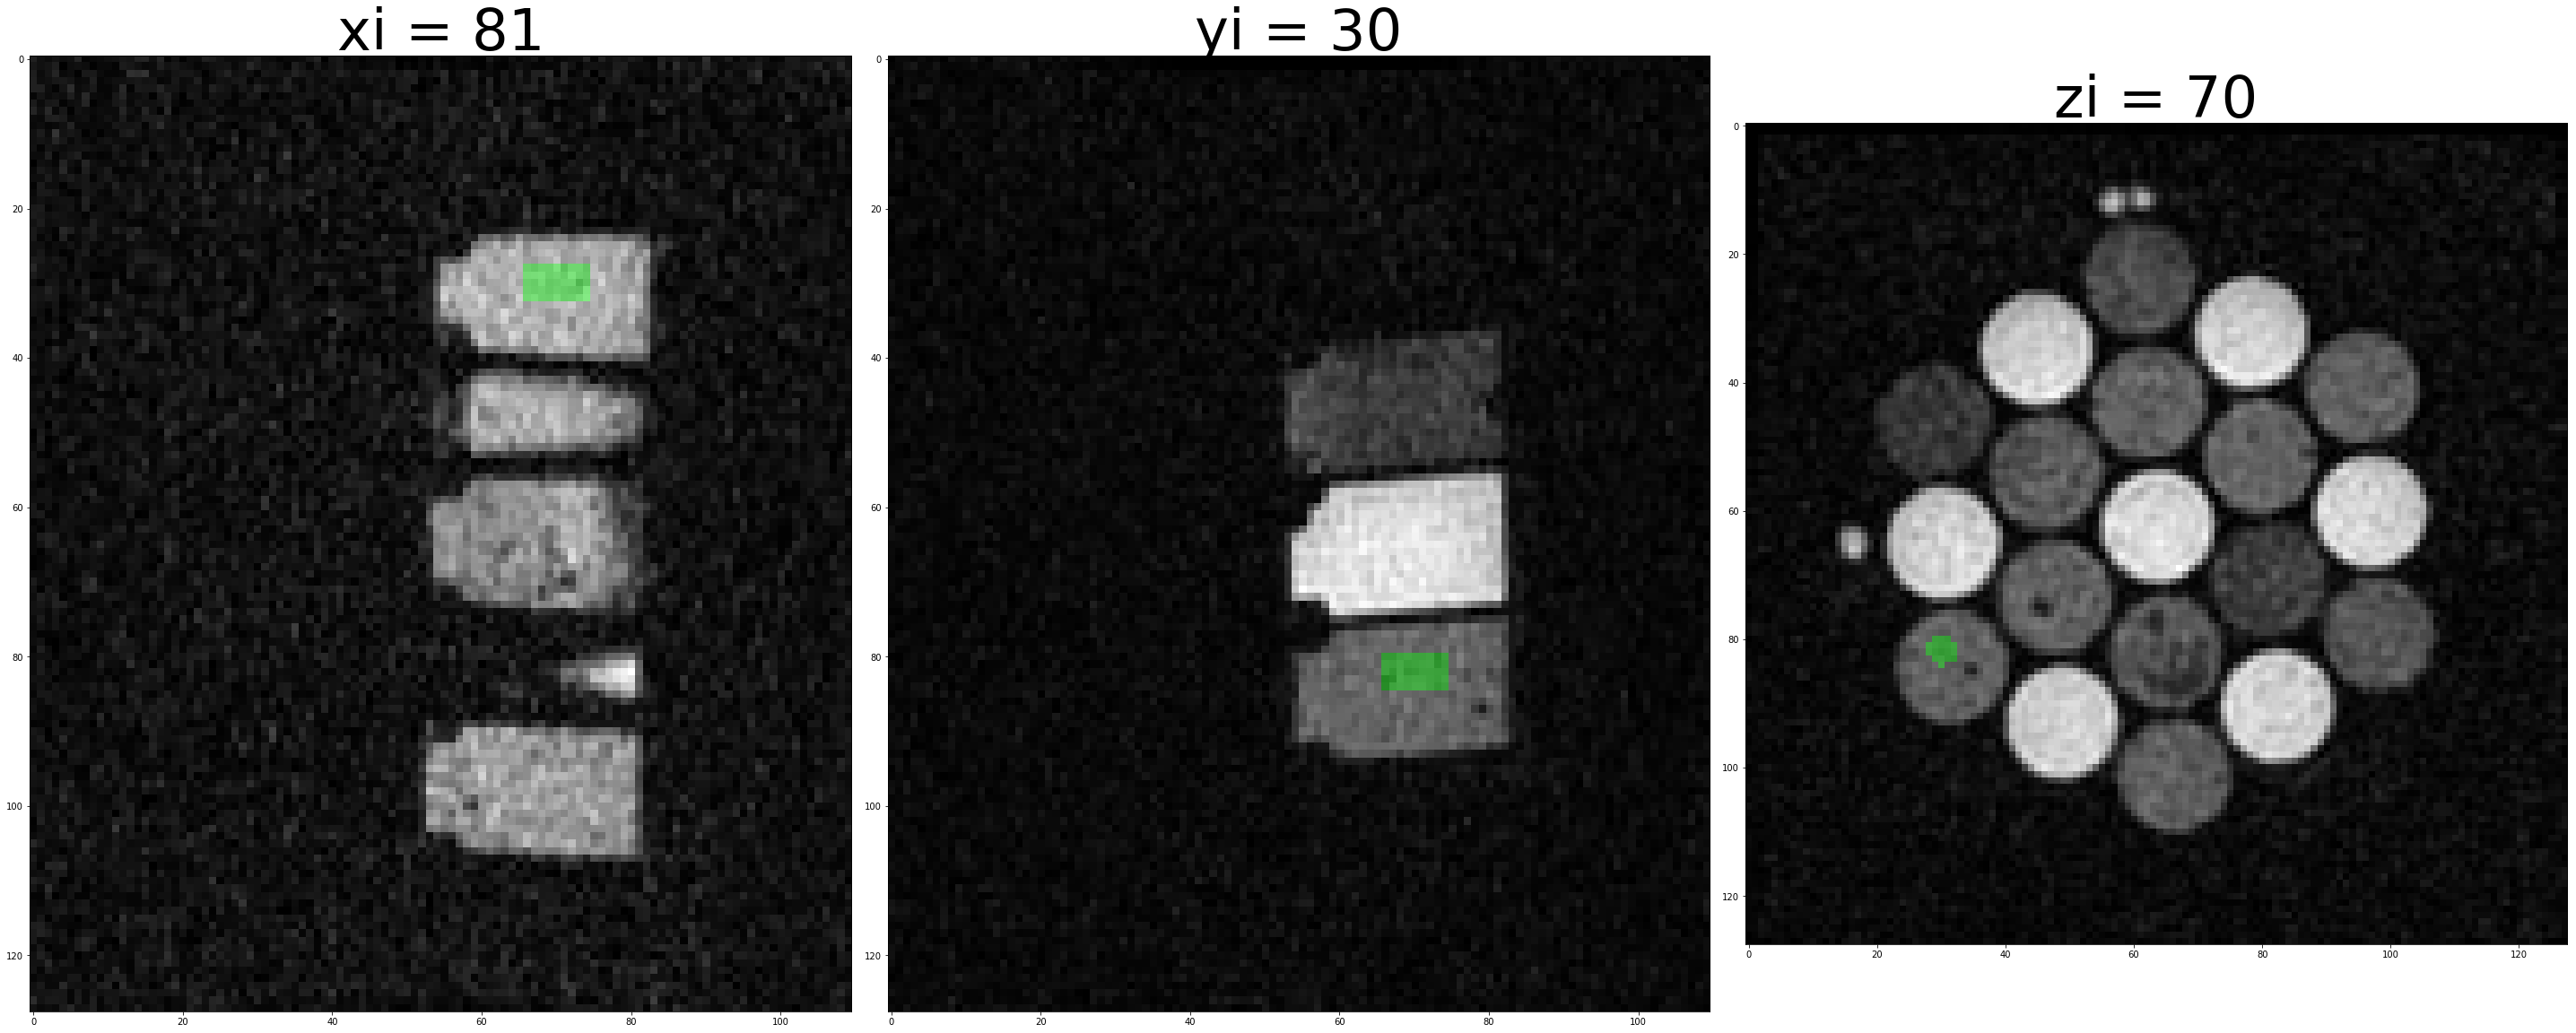

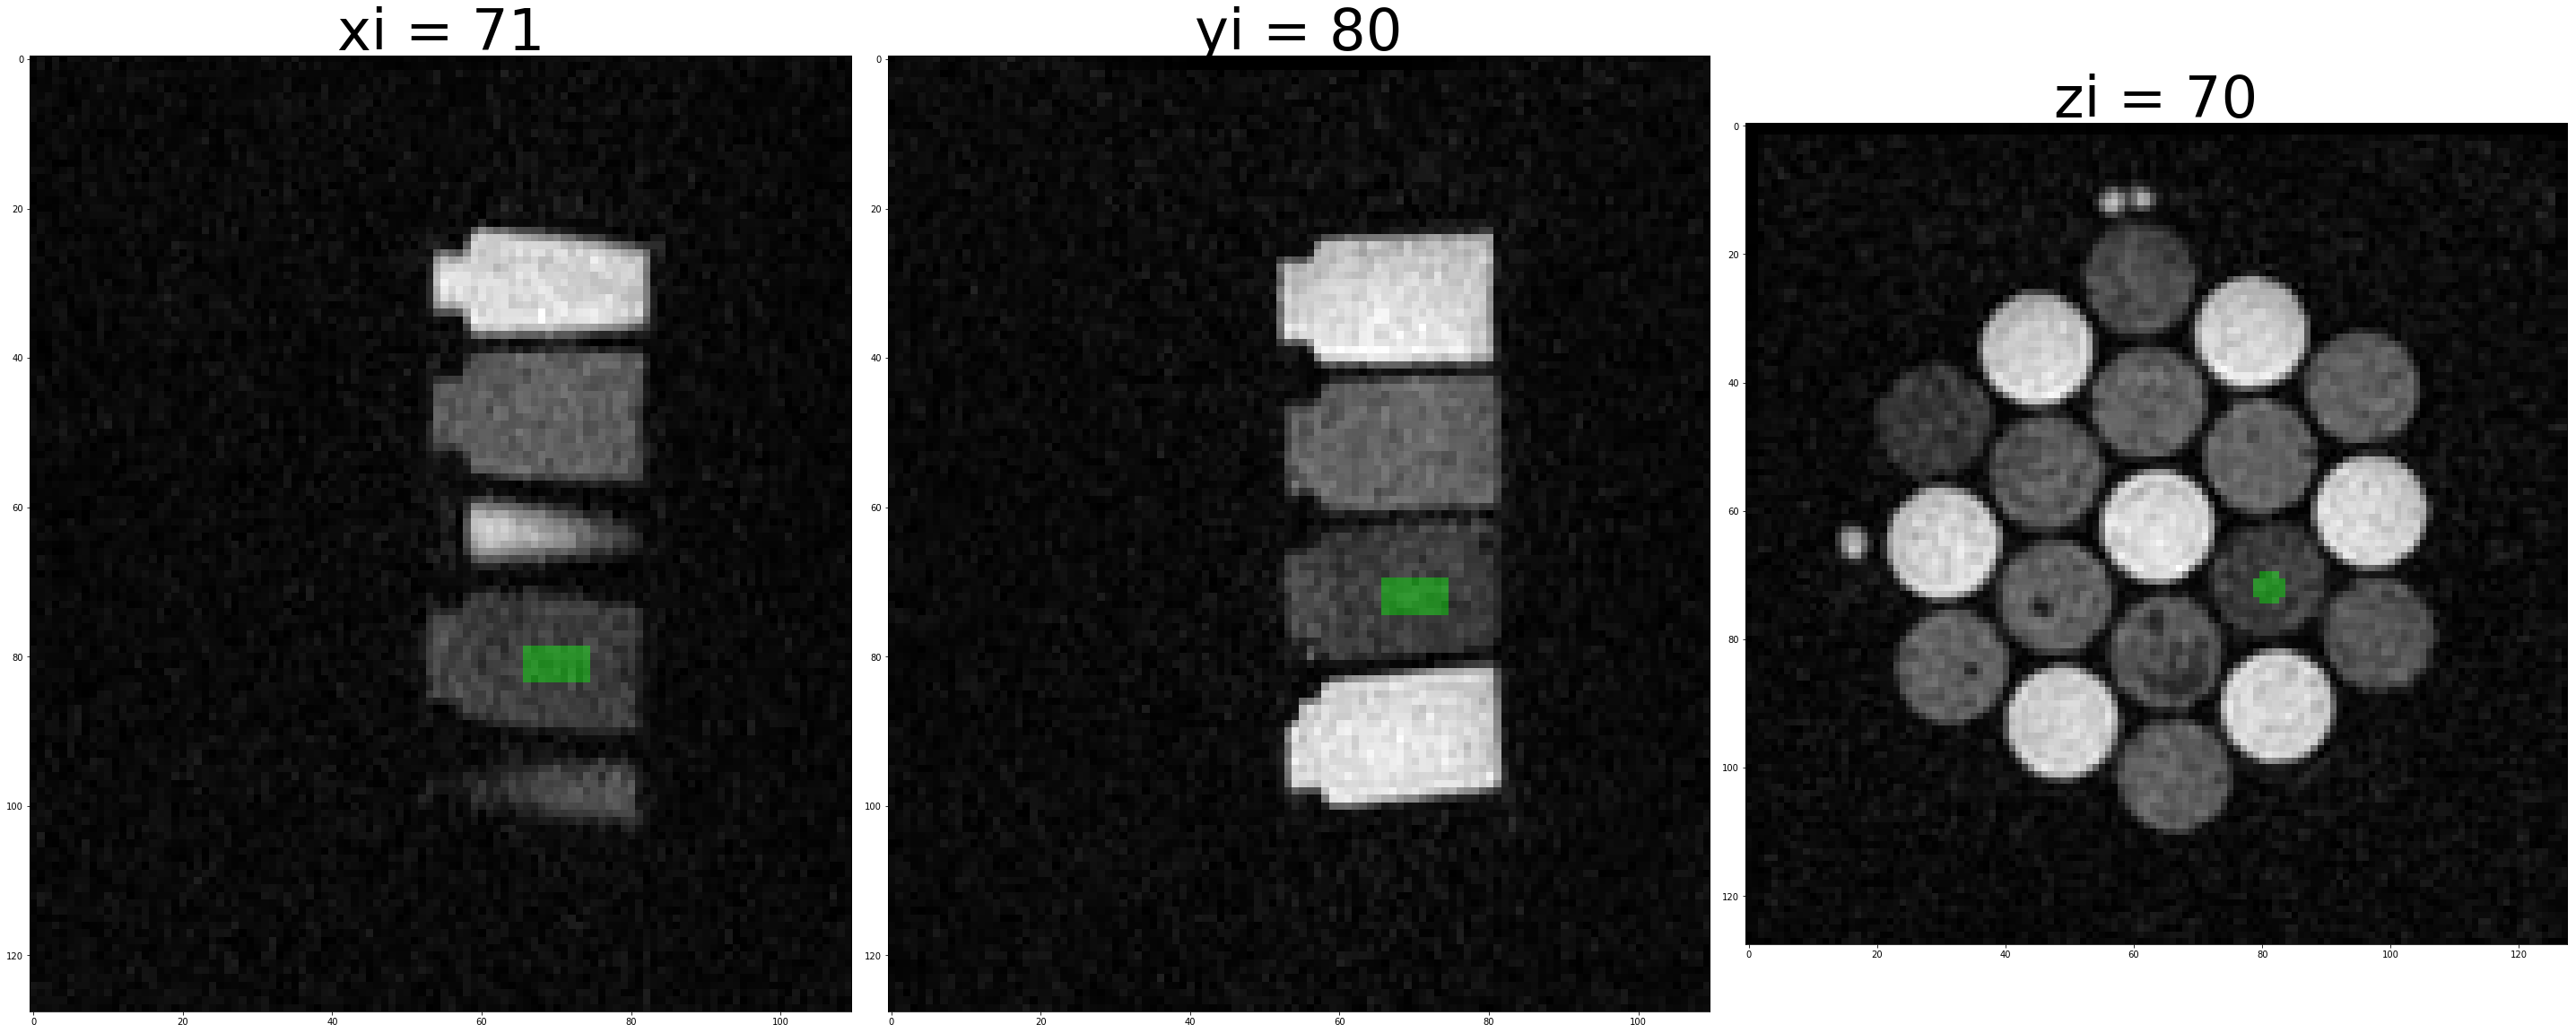

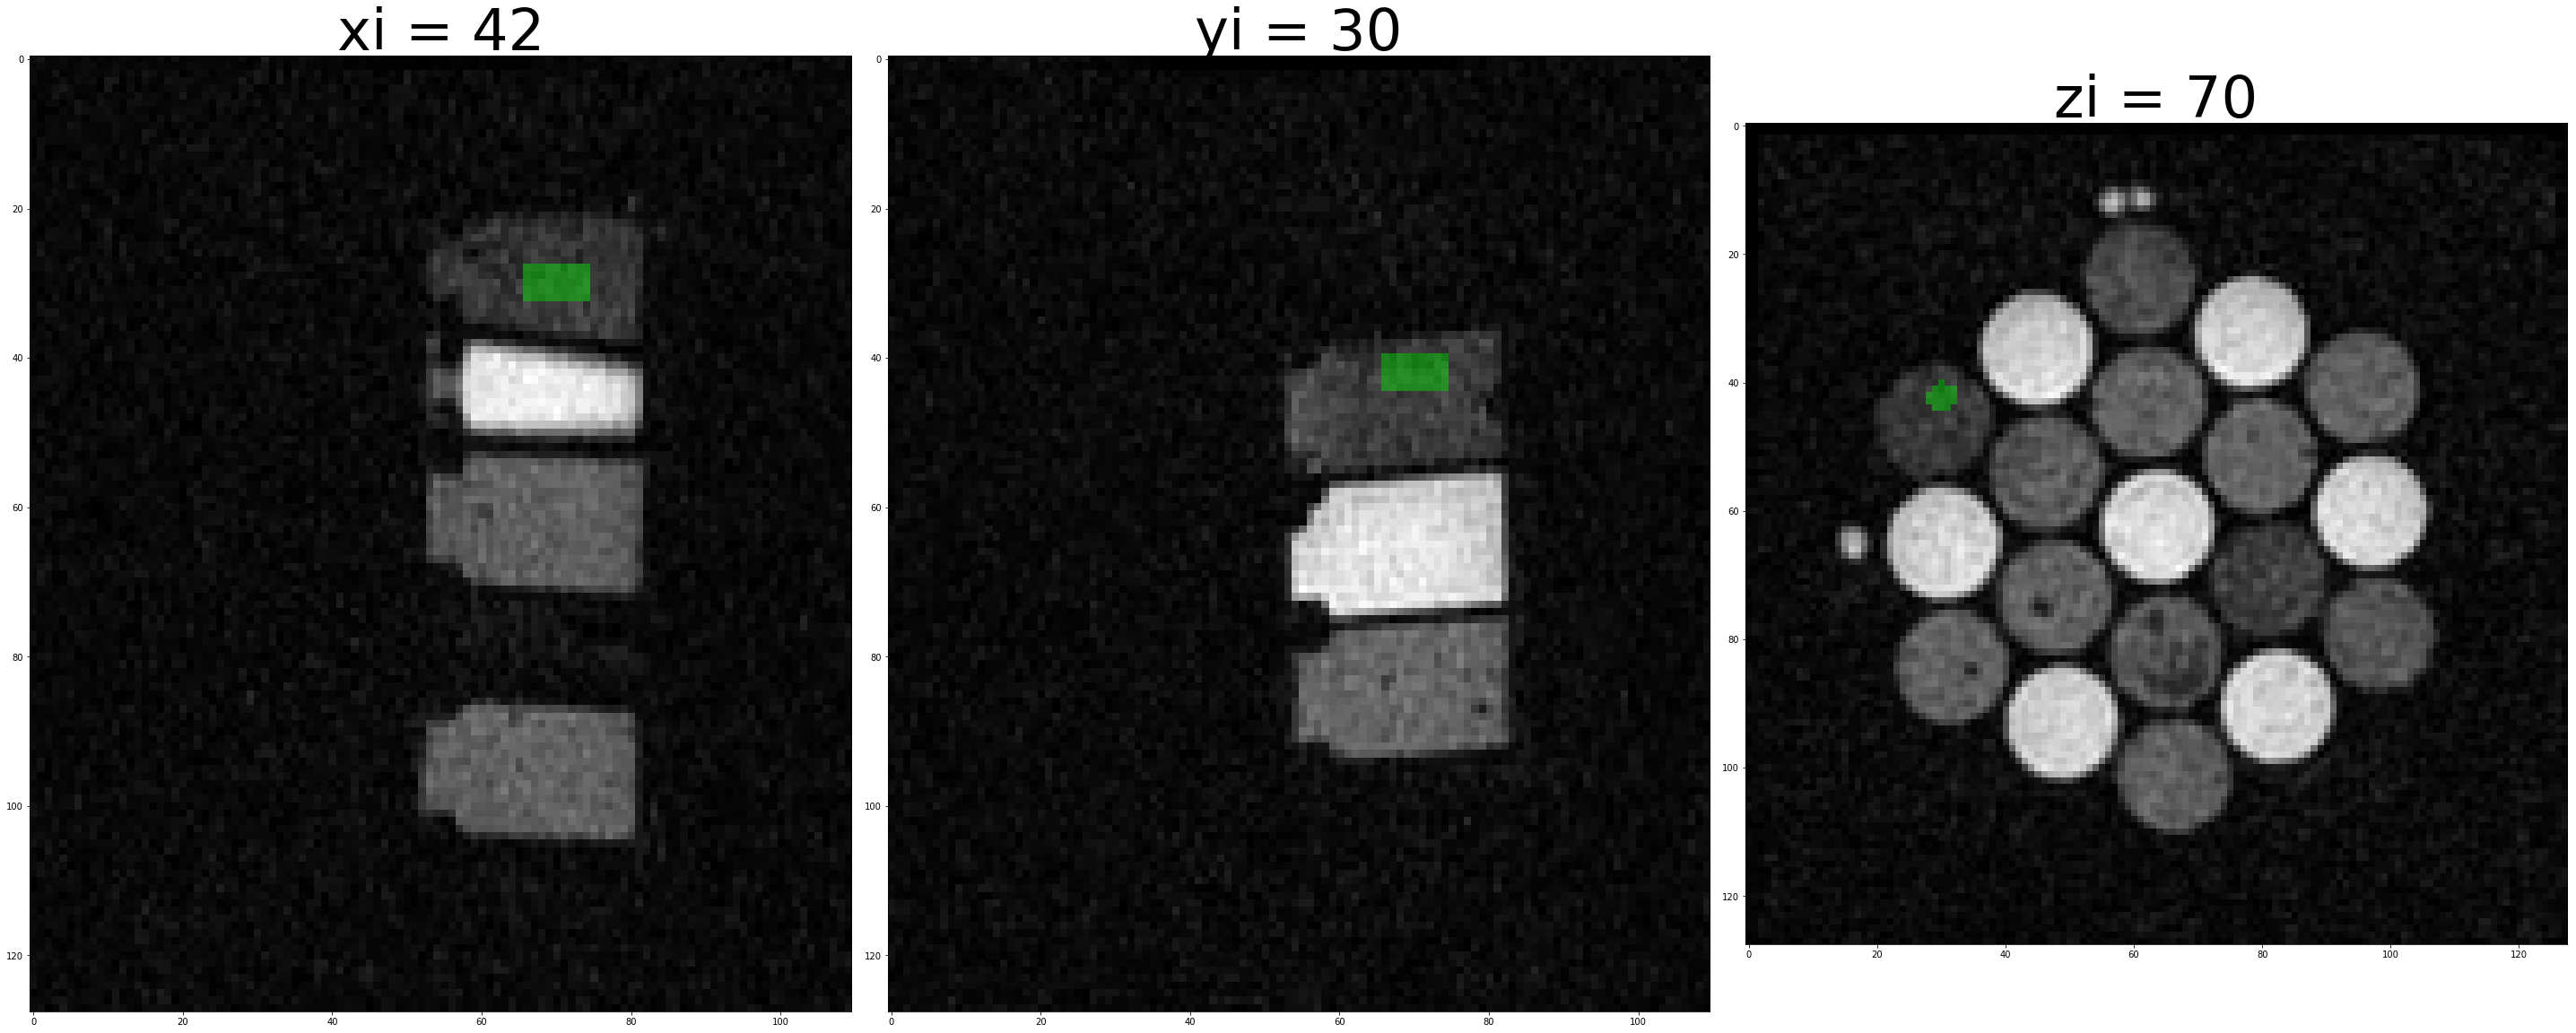

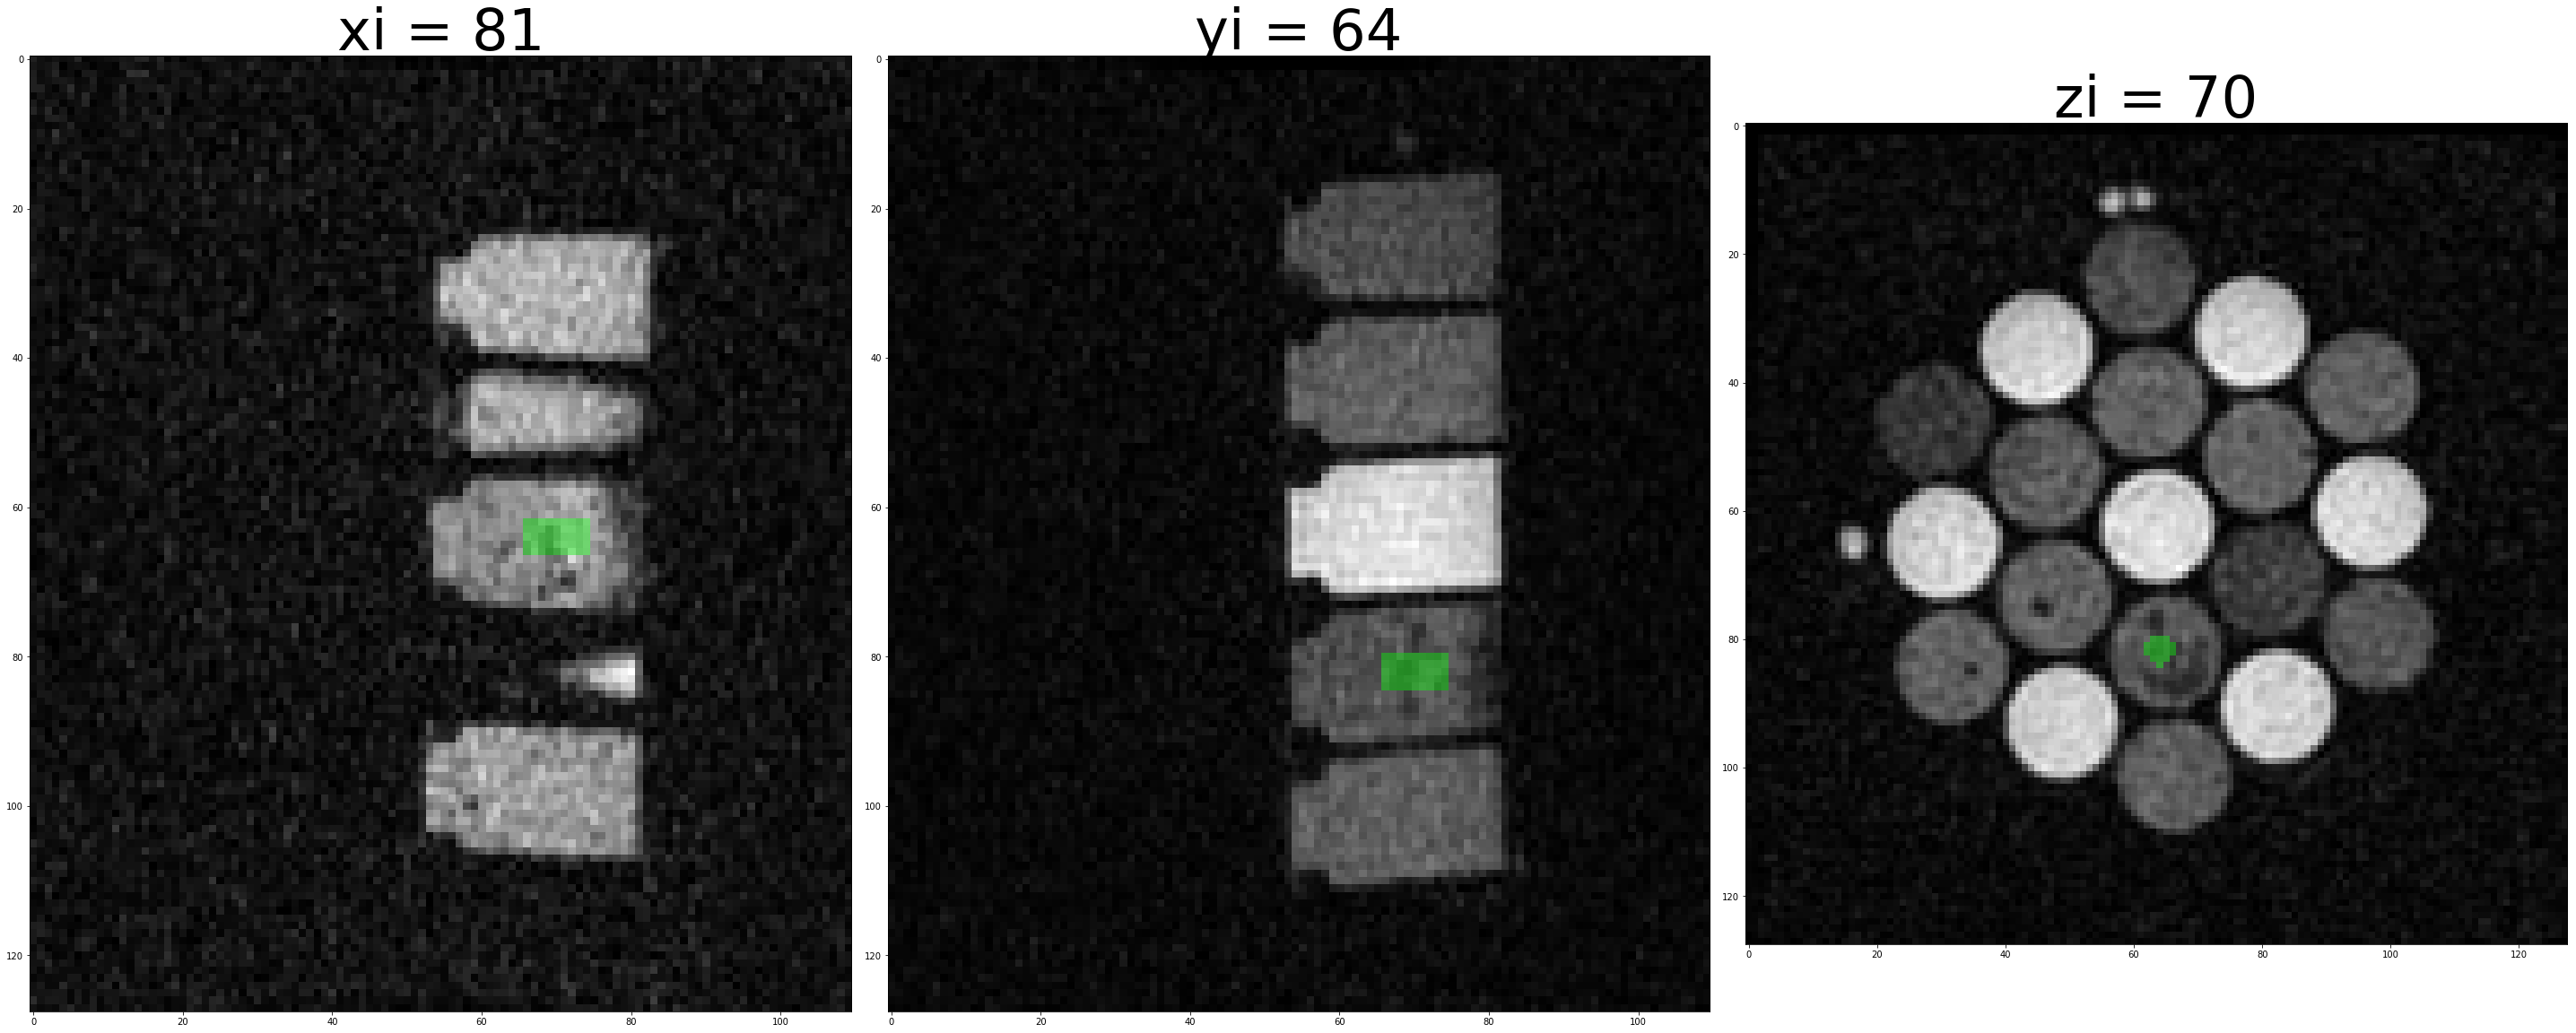

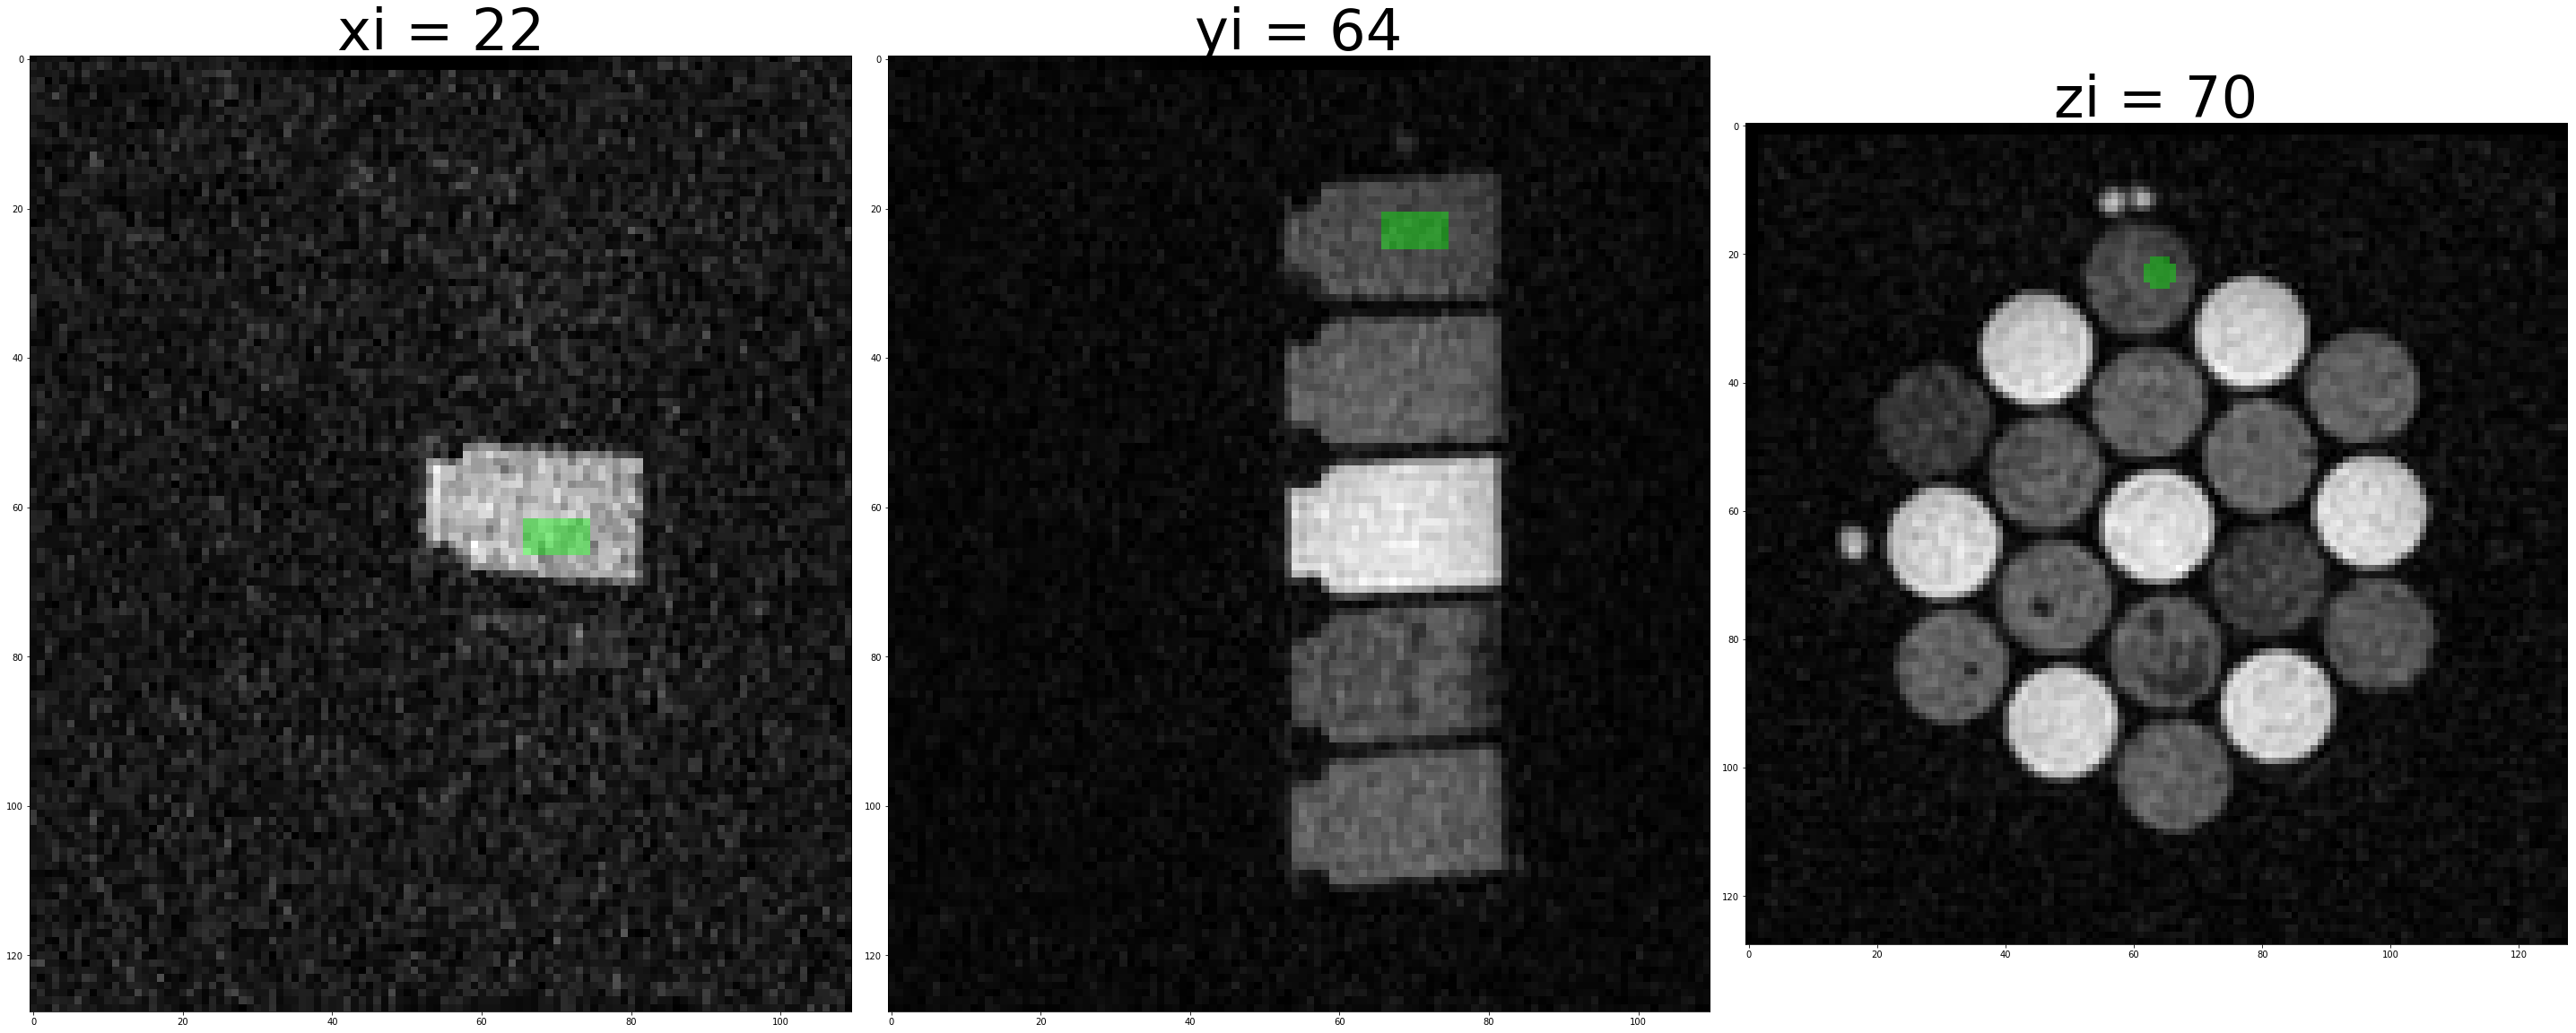

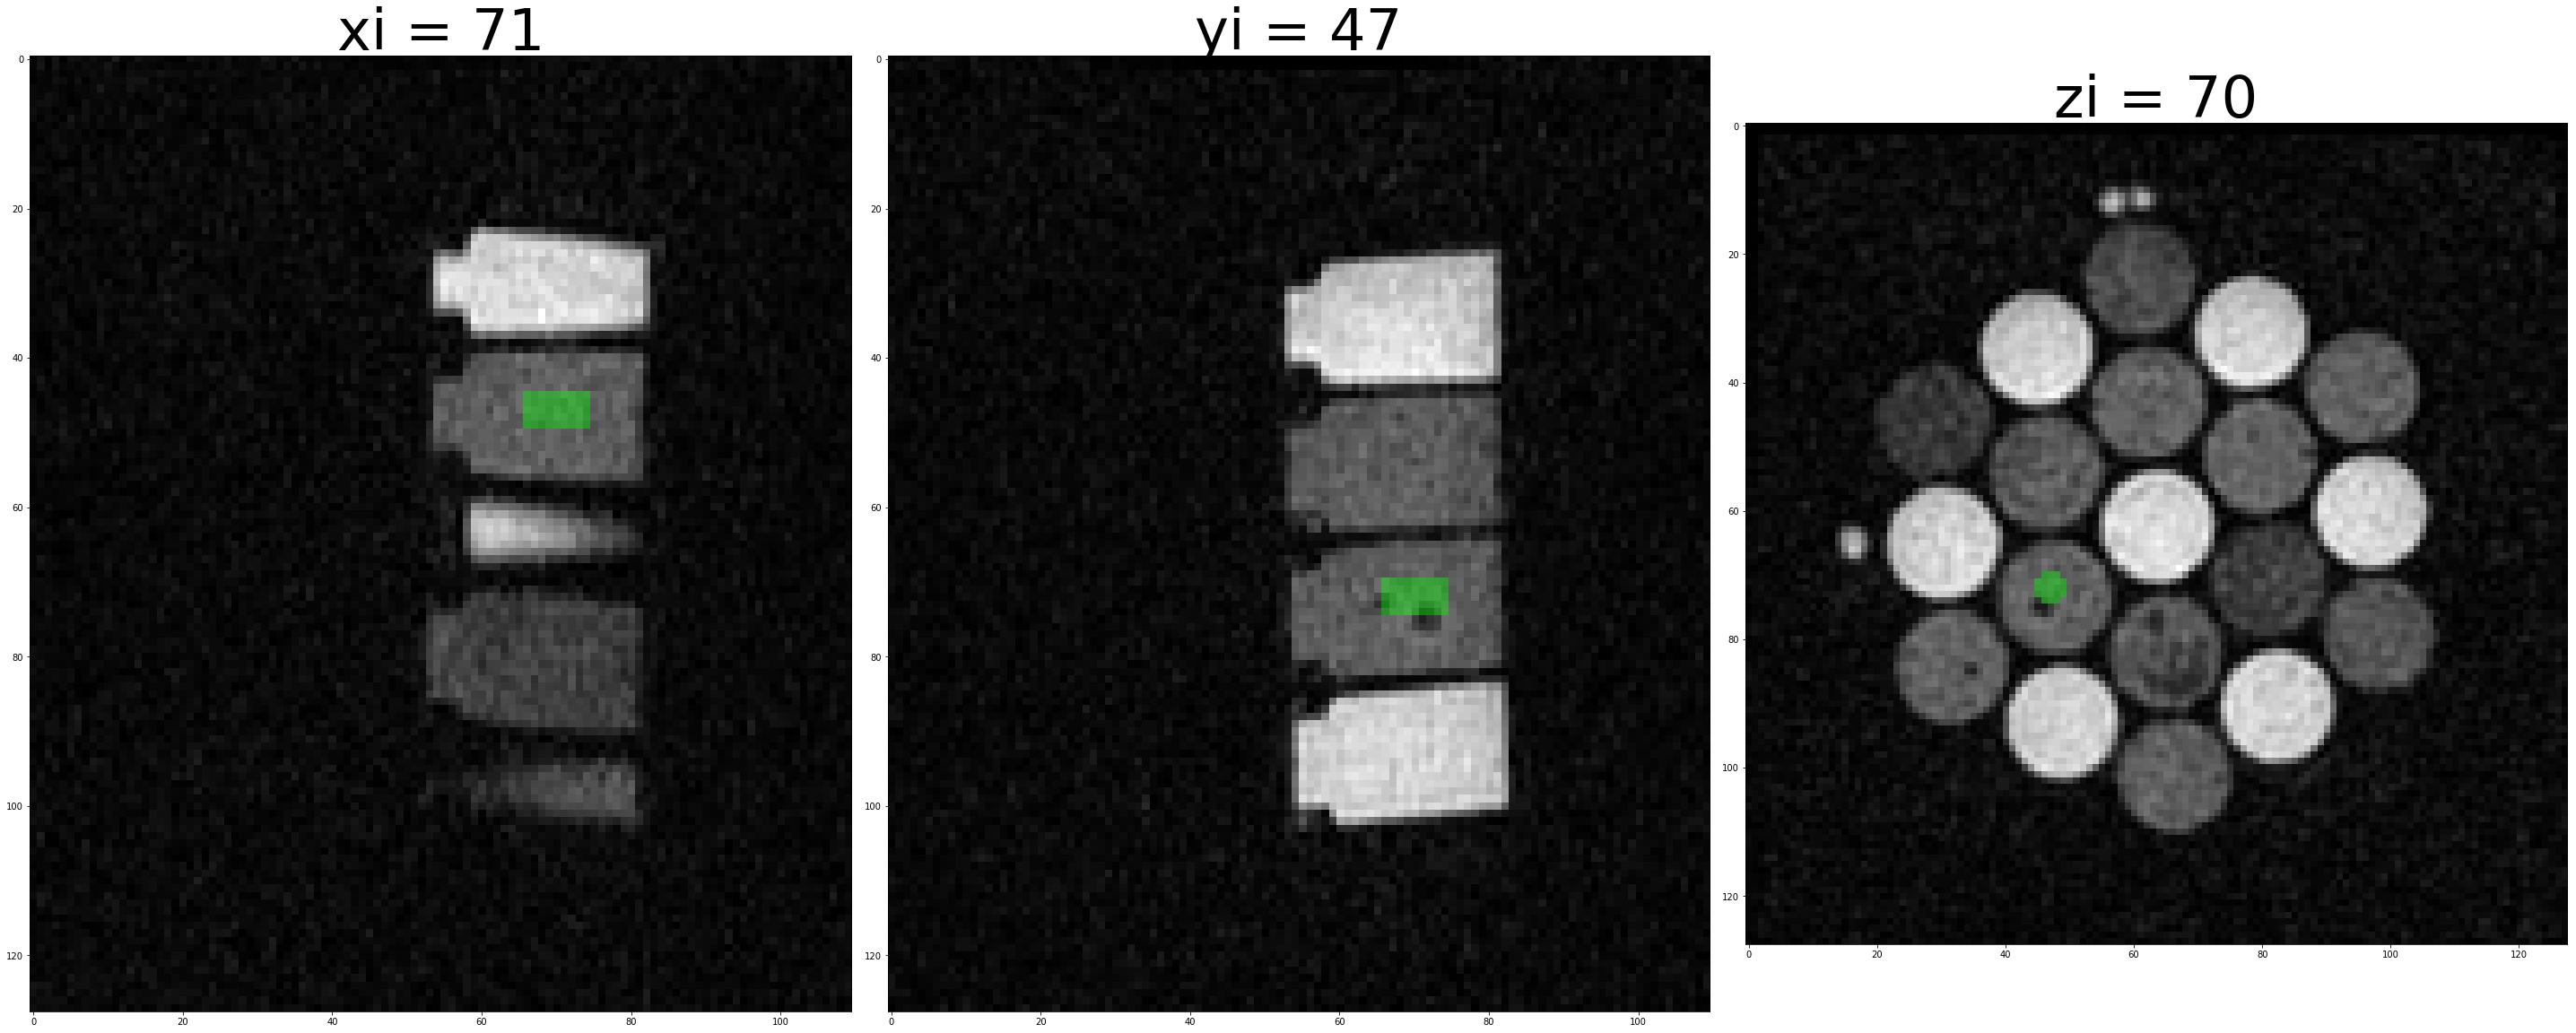

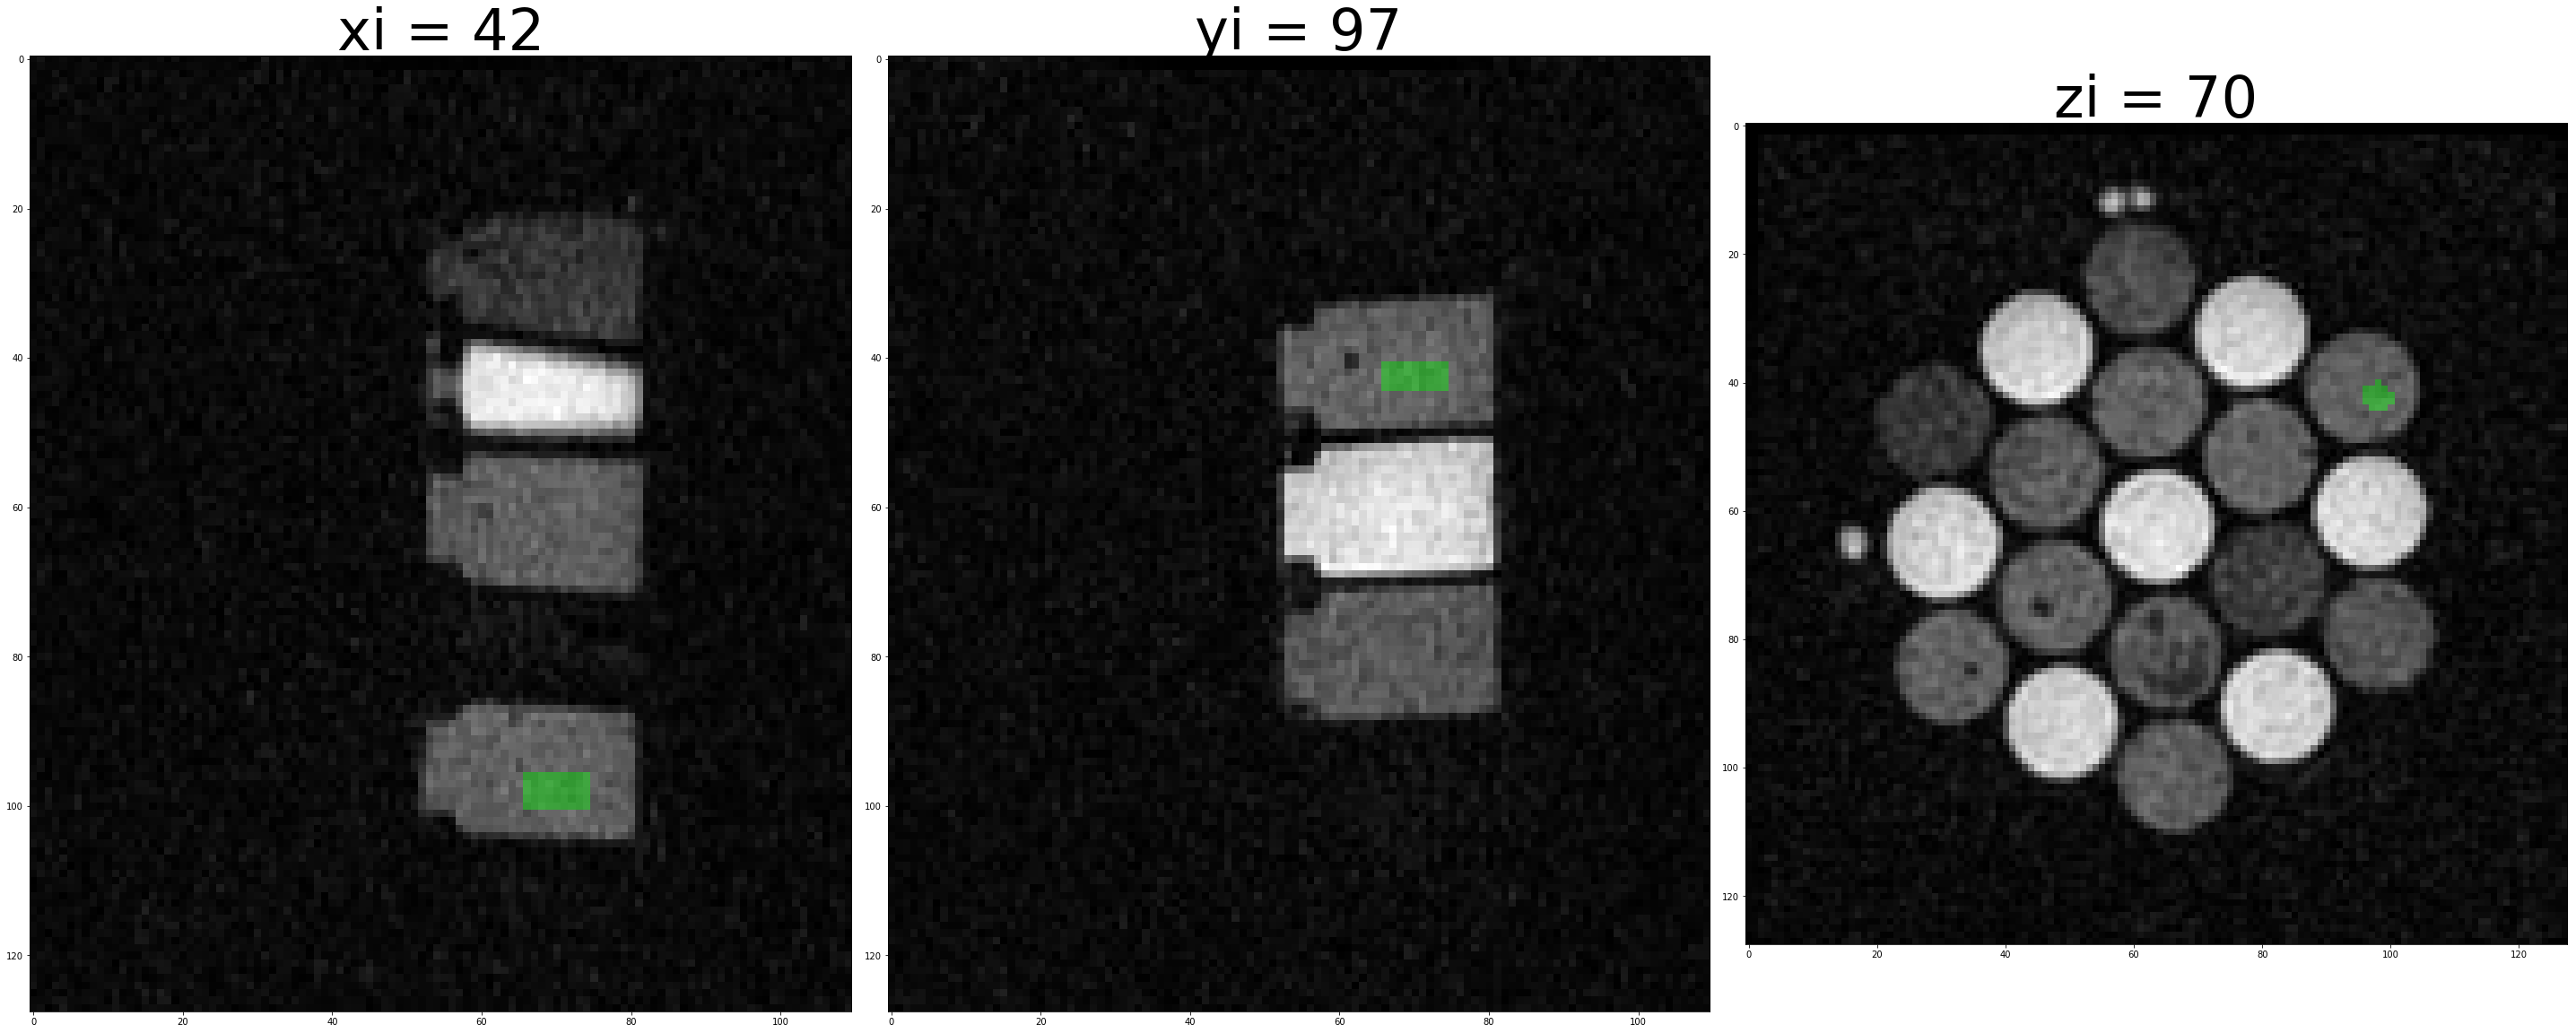

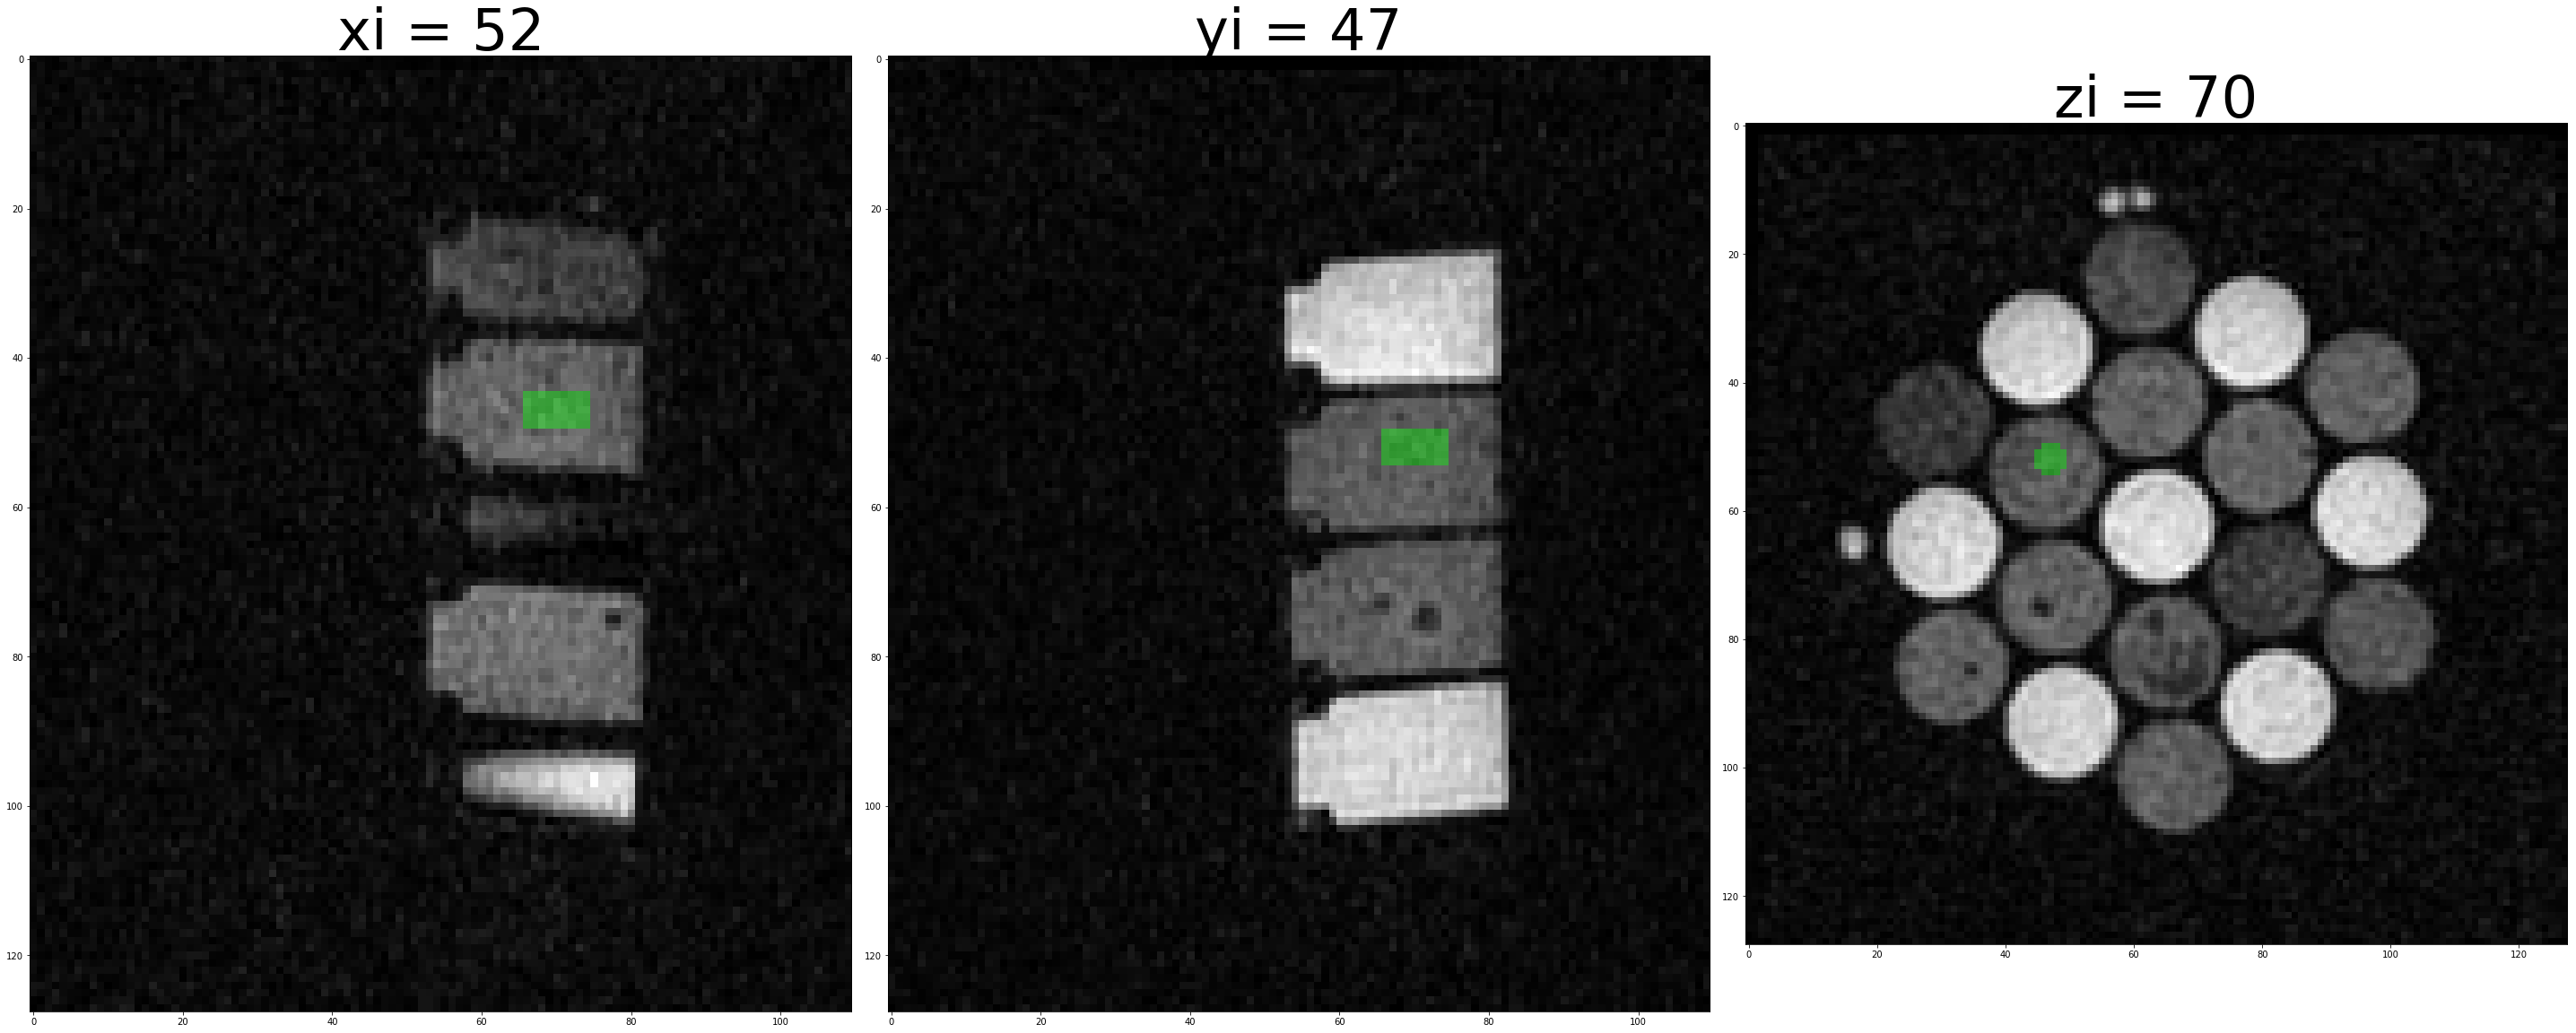

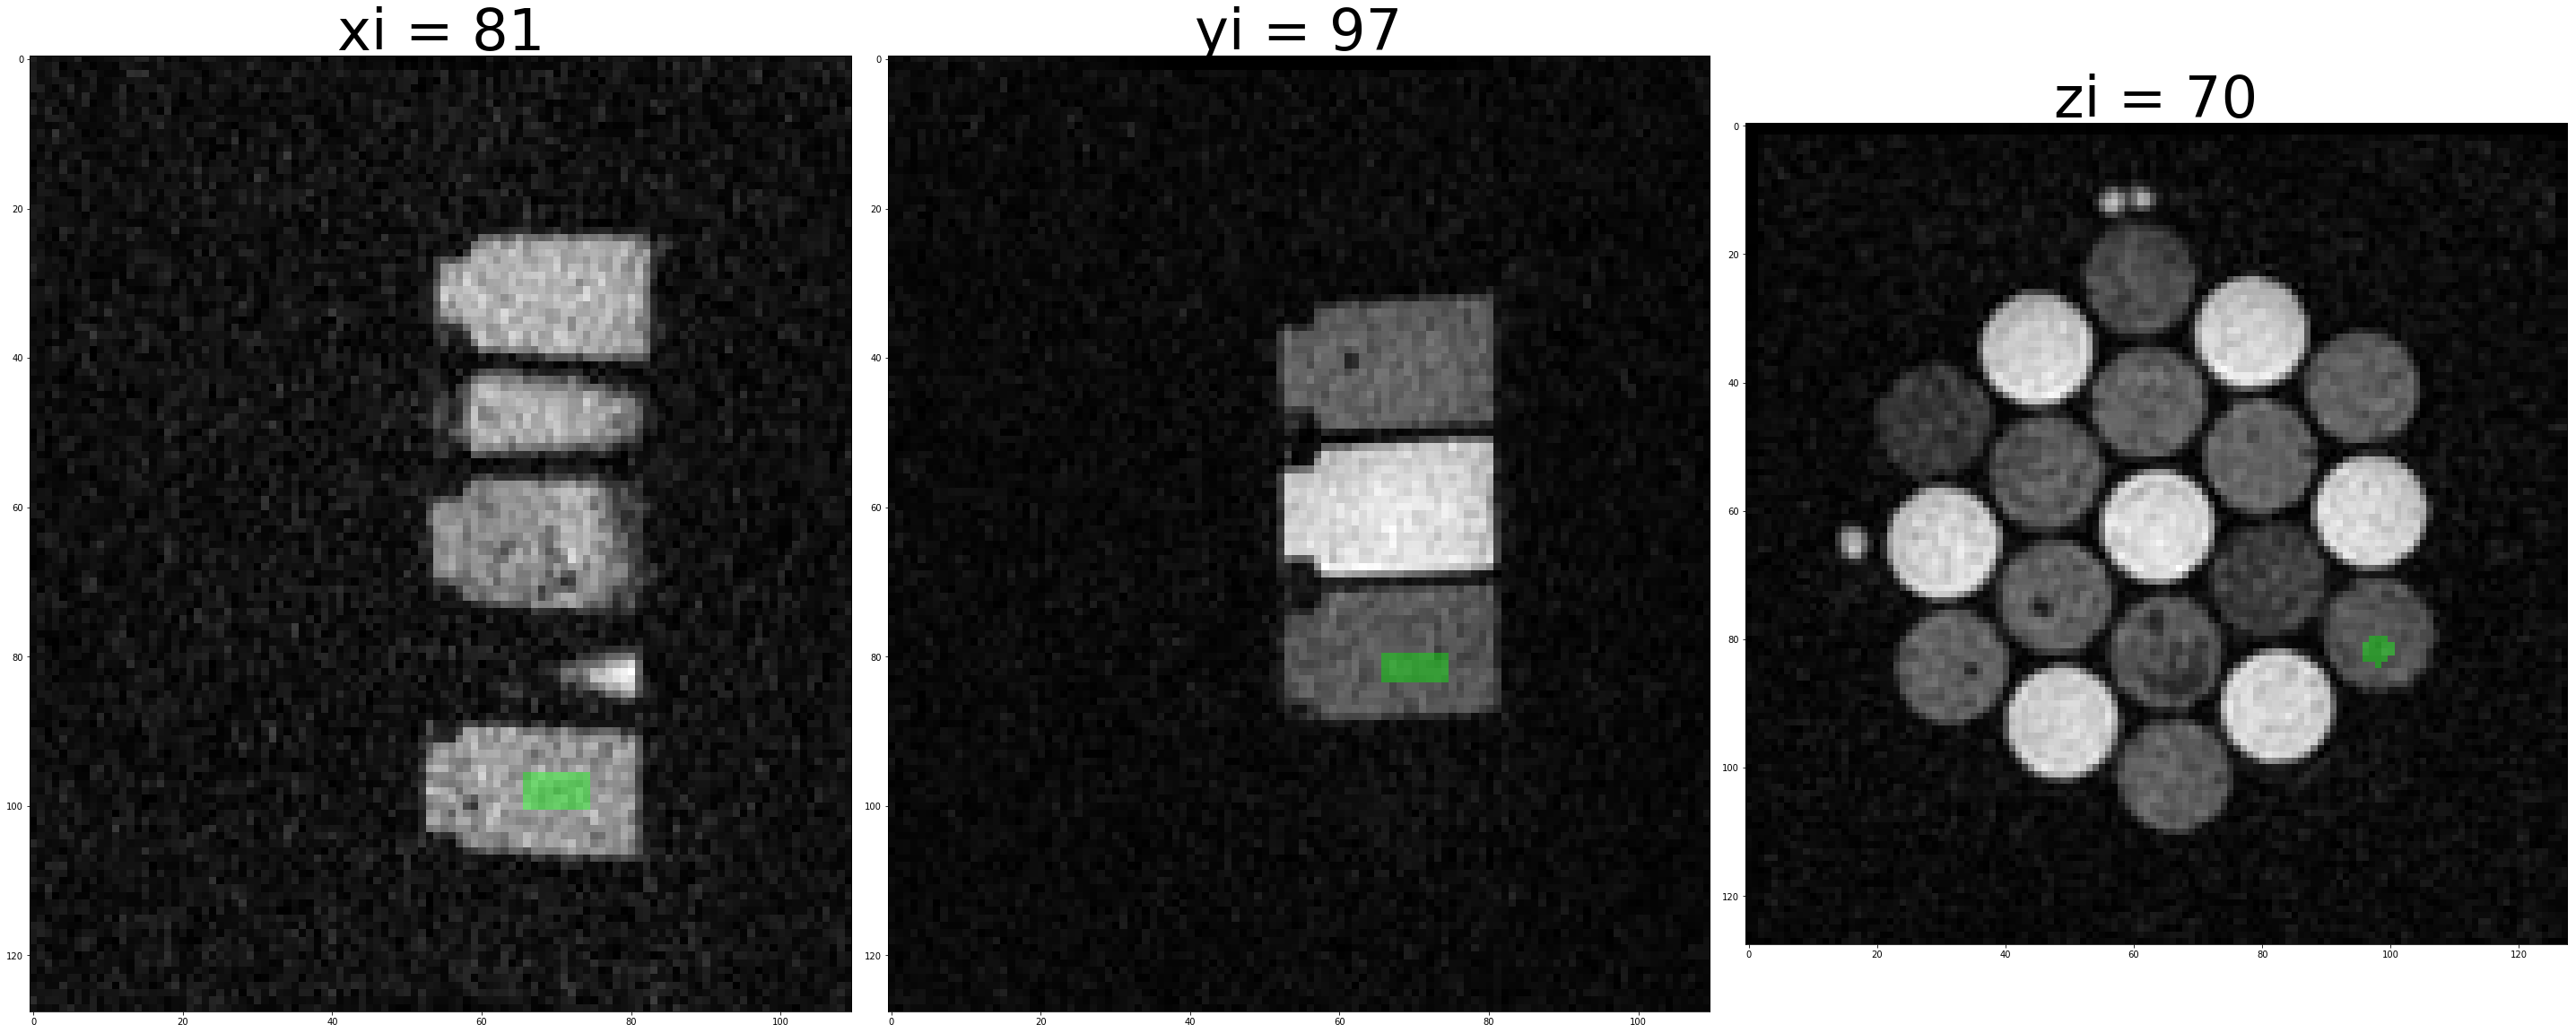

In [7]:
# Plot each ROI through the center

plt.close()
alpha = 0.4

for ci, roi in enumerate(roi_info):
    fig, ax = plt.subplots(1, 3, figsize=(40.0, 20.0))
    
    # Plot a slice in each axis through the ROI center
    cx, cy, cz = (
        int(roi['cx']/dx),
        int(roi['cy']/dy),
        int(roi['cz']/dz)
    )
        
    roi_data = np.zeros((nx, ny, nz, 4), dtype=np.float)
    roi_data[:,:,:,1] = roi['mask']
    roi_data[:,:,:,3] = alpha * roi['mask']
    
    ax[0].imshow(vol[cx,:,:], cmap=plt.cm.gray)
    ax[0].imshow(roi_data[cx,:,:,:])
    ax[0].set_title('xi = {:d}'.format(cx), fontsize=64)
    
    ax[1].imshow(vol[:,cy,:], cmap=plt.cm.gray)
    ax[1].imshow(roi_data[:,cy,:,:])
    ax[1].set_title('yi = {:d}'.format(cy), fontsize=64)
    
    ax[2].imshow(vol[:,:,cz], cmap=plt.cm.gray)
    ax[2].imshow(roi_data[:,:,cz,:])
    ax[2].set_title('zi = {:d}'.format(cz), fontsize=64)
    
    fig.patch.set_facecolor('white')
    fig.tight_layout()

plt.show()


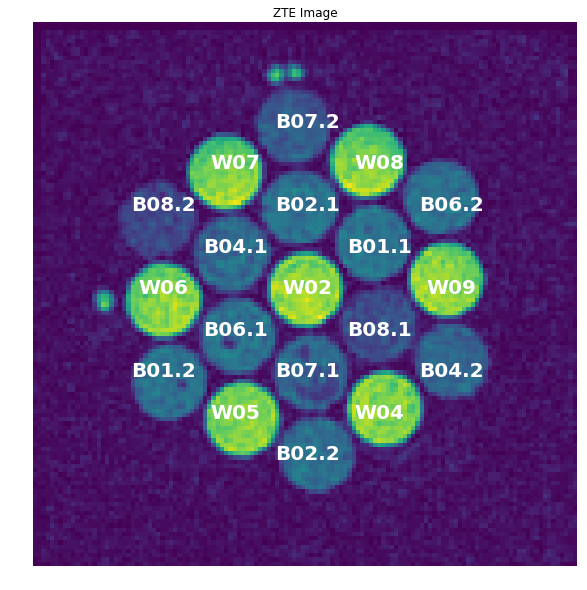

In [8]:
plt.close()
fig = plt.figure(figsize=(10.0, 10.0))

sli = 70
scl_slice = (vol[:,:,sli] - np.min(vol[:,:,sli]))/(np.max(vol[:,:,sli]) - np.min(vol[:,:,sli]))
plt.imshow(scl_slice)

fig.patch.set_facecolor('white')
plt.gca().axis('off')
fig.savefig('ZTE_unlabeled_slice.svg')

for ci,roi in enumerate(roi_info):
    cx = roi['cx']/dx
    cy = roi['cy']/dy
    #plt.plot(cx, cy, 'rx')
    th = np.linspace(0.0, 2*np.pi, 100)
    xx = rc/dy * np.cos(th) + cy
    yy = rc/dx * np.sin(th) + cx
    label = roi['label'].split('(')[1].split(')')[0]
    plt.text(cy, cx, label, fontdict = {
        'color': 'white',
        'fontsize': 20,
        'fontweight' : 'bold',
        'horizontalalignment' : 'center',
        'verticalalignment' : 'center'
    })

plt.title('ZTE Image')
plt.show()

fig.savefig('ZTE_labeled_slice.svg')

In [9]:
# Compute ROI mean signal

vol2 = np.zeros()
for roi in roi_info:
    roi['vxsig_zte'] = []
    for zi in range(nz):
        for yi in range(ny):
            for xi in range(nx):
                if (roi['mask'][xi, yi, zi]):
                    roi['vxsig_zte'].append(vol[xi, yi, zi])
    
    roi['vxsig_zte'] = np.array(roi['vxsig_zte'], dtype=vol.dtype)
    roi['mean_zte_sig'] = np.mean(roi['vxsig_zte'])

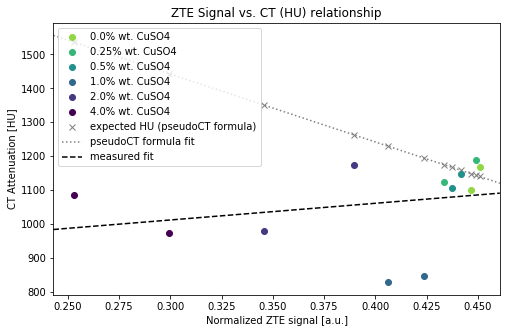

In [77]:
import json
import re

cid_re = re.compile('[A-Z][0-9]{2}\.?[0-9]?')
with open('ct-results.json','r') as ctres:
    ct_results = json.loads(ctres.read())

ct_num = []
norm_zte_sig = []
zte_ref_sig = roi_info[1]['mean_zte_sig']
for roi in roi_info:
    cid = cid_re.search(roi['label']).group()
    ct_num.append(ct_results[cid]['data']['CT Mean HU value'])
    norm_zte = roi['mean_zte_sig']/zte_ref_sig
    norm_zte_sig.append(norm_zte)

ct_num = np.array(ct_num)
norm_zte_sig = np.array(norm_zte_sig)

zte_ct_fit = np.polyfit(norm_zte_sig[7:], ct_num[7:], 1)
zte_ct_fn = np.poly1d(zte_ct_fit)
pct_fn = lambda z : -2000.0 * (z - 1) + 42

plt.close()
fig = plt.figure(figsize=(8.0,5.0))

from matplotlib import cm
cc = cm.get_cmap('viridis')

# B01 (9, 10): 0.0% wt. CuSO4
plt.plot(norm_zte_sig[9:11], ct_num[9:11], 'o', color=cc(5.0/6.0), zorder=4, label='0.0% wt. CuSO4')
# B06 (15, 16): 0.25% wt. CuSO4
plt.plot(norm_zte_sig[15:17], ct_num[15:17], 'o', color=cc(4.0/6.0), zorder=4, label='0.25% wt. CuSO4')
# B02 (7, 8): 0.5% wt. CuSO4
plt.plot(norm_zte_sig[7:9], ct_num[7:9], 'o', color=cc(3.0/6.0), zorder=4, label='0.5% wt. CuSO4')
# B04 (17, 18): 1.0% wt. CuSO4
plt.plot(norm_zte_sig[17:19], ct_num[17:19], 'o', color=cc(2.0/6.0), zorder=4, label='1.0% wt. CuSO4')
# B07 (13, 14): 2.0% wt. CuSO4
plt.plot(norm_zte_sig[13:15], ct_num[13:15], 'o', color=cc(1.0/6.0), zorder=4, label='2.0% wt. CuSO4')
# B08 (11, 12): 4.0% wt. CuSO4
plt.plot(norm_zte_sig[11:13], ct_num[11:13], 'o', color=cc(0.0/6.0), zorder=4, label='4.0% wt. CuSO4')

plt.plot(norm_zte_sig[7:], pct_fn(norm_zte_sig[7:]), 'x', color=[0.5,0.5,0.5], zorder=1, label='expected HU (pseudoCT formula)')

plotbnds = plt.gca().get_xlim()
zz = np.linspace(*plotbnds, 10)
plt.plot(zz, pct_fn(zz), ':', color=[0.5,0.5,0.5], zorder=2, label='pseudoCT formula fit')
plt.plot(zz, zte_ct_fn(zz), 'k--', zorder=3, label='measured fit')

plt.title('ZTE Signal vs. CT (HU) relationship')
plt.xlabel('Normalized ZTE signal [a.u.]')
plt.ylabel('CT Attenuation [HU]')

#plt.legend(['measured', 'computed', 'computed fit', 'measured fit'])
plt.legend()

plt.gca().set_xlim(plotbnds)
plt.gcf().set_facecolor('white')
plt.show()

fig.savefig('20180413.ZTECT.svg', dpi=300.0)
fig.savefig('20180413.ZTECT.png', dpi=300.0)

In [13]:

results = {}
for roi in roi_info:
    cid = cid_re.search(roi['label']).group()
    results[cid] = {
        'label' : roi['label'],
        'data' : {
            'ZTE Mean Signal' : roi['mean_zte_sig'],
        }
    }

with open('zte-results.json','w') as jout:
    jout.write(json.dumps(results, indent=4, sort_keys=True))
